# Final Project Submission

Please fill out:
* Student name: Gabriel Araujo
* Student pace: part time
* Scheduled project: August 15th, 2:30 
* Instructor name: James Irving
* Blog post URL:

# INTRODUCTION

I have been tasked with investigating house sales in the King County area and building a model to suggest home improvements in order to increase house value.

The following questions will be answered in this project:

1- Which feature generates the best model, zip codes or sub regions?

2 - Which house attributes have a high impact in sale price and which attributes have the least impact?

3 - Does transforming the target value improve model efficiency?


# OBTAIN

In [1]:
#IMPORTING
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')

from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import train_test_split

In [2]:
#OPENING DATASET 
pd.set_option('display.max_columns',0)
df = pd.read_csv('kc_house_data.csv')
df.drop(columns = 'id',inplace = True)
df

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,5/21/2014,360000.0,3,2.50,1530,1131,3.0,0.0,0.0,3,8,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,2/23/2015,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,3,8,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,6/23/2014,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,3,7,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,1/16/2015,400000.0,3,2.50,1600,2388,2.0,NaN,0.0,3,8,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


In [3]:
#GETTING DATA INFO
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(10), object(2)
memory usage: 3.3+ MB


In [4]:
#GETTING DATA BASIC STATS
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21534.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,0.233863,3.409825,7.657915,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.765686,0.650546,1.173200,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [5]:
#LOOKING AT NULL VALUES
df.isna().sum()

date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

# SCRUB (DATA CLEANING)

In [6]:
#WANT TO FILL ALL NULL VALUES IN WATERFRONT WITH DISTRIBUTION OF 146:19075
s = df.waterfront.value_counts(normalize = True)
print(s)

0.0    0.992404
1.0    0.007596
Name: waterfront, dtype: float64


In [7]:
waterfront_null = df.waterfront.isnull()
df.loc[waterfront_null,'waterfront'] = np.random.choice(s.index,size=len(df[waterfront_null]),p=s.values)
print(df.waterfront.value_counts())

0.0    21426
1.0      171
Name: waterfront, dtype: int64


In [8]:
#CONVERTING DATE FROM OBJECT TO DATE
df.date = pd.to_datetime(df.date)

In [9]:
df[df.sqft_basement == '?']

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
6,2014-06-27,257500.0,3,2.25,1715,6819,2.0,0.0,0.0,3,7,1715,?,1995,0.0,98003,47.3097,-122.327,2238,6819
18,2014-12-05,189000.0,2,1.00,1200,9850,1.0,0.0,0.0,4,7,1200,?,1921,0.0,98002,47.3089,-122.210,1060,5095
42,2014-07-07,861990.0,5,2.75,3595,5639,2.0,0.0,0.0,3,9,3595,?,2014,0.0,98053,47.6848,-122.016,3625,5639
79,2015-03-23,720000.0,4,2.50,3450,39683,2.0,0.0,0.0,3,10,3450,?,2002,0.0,98010,47.3420,-122.025,3350,39750
112,2014-09-16,272500.0,3,1.75,1540,12600,1.0,0.0,0.0,4,7,1160,?,1980,0.0,98038,47.3624,-122.031,1540,11656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21442,2014-07-11,504600.0,5,3.00,2360,5000,1.0,0.0,0.0,3,7,1390,?,2008,0.0,98103,47.6931,-122.330,2180,5009
21447,2014-07-21,337500.0,4,2.50,2330,4907,2.0,0.0,0.0,3,7,2330,?,2013,NaN,98042,47.3590,-122.081,2300,3836
21473,2015-01-20,352500.0,2,2.50,980,1010,3.0,0.0,0.0,3,8,980,?,2008,0.0,98117,47.6844,-122.387,980,1023
21519,2014-10-15,332000.0,4,2.50,2380,5737,2.0,0.0,0.0,3,7,2380,?,2010,0.0,98023,47.2815,-122.356,2380,5396


In [10]:
#SEEING IF HOUSES WITH '?' FOR SQFT_BASEMENT ACTUALLY HAVE A BASEMENT AND FILLING MISSING VALUES
for index, value in enumerate(df.sqft_basement):
    if value == '?':
        if df.sqft_living[index] != df.sqft_above[index]:
            df.sqft_basement[index] = df.sqft_living[index] - df.sqft_above[index]
        elif df.sqft_living[index] == df.sqft_above[index]:
            df.sqft_basement[index] = 0

C:\Users\Biel_\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\Biel_\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [11]:
#REPLACING ALL NULL VALUES IN YR_RENOVATED TO 0 BECAUSE MAJORITY IS 0
for index, col in enumerate(df.yr_renovated.isnull()):
    if col == True:
        df.yr_renovated[index] = 0
df

C:\Users\Biel_\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,2014-05-21,360000.0,3,2.50,1530,1131,3.0,0.0,0.0,3,8,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,2015-02-23,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,3,8,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,2014-06-23,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,3,7,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,2015-01-16,400000.0,3,2.50,1600,2388,2.0,0.0,0.0,3,8,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


In [12]:
#TURNING VALUES FROM FLOAT TO INT
float_list = ['sqft_basement','waterfront','yr_renovated','sqft_basement']
for col in float_list:
    df[col] = pd.to_numeric(df[col]).astype(int).round(0)

In [13]:
#CREATING YEAR SOLD AND RENOVATION FRESHNESS COLUMNS
df['year_sold'] = pd.DatetimeIndex(df['date']).year
df['renovated'] = 0

In [14]:
#REPLACING 2015 YEAR RENOVATED AND YEAR BUILT WITH 2014 BECAUSE HOUSE WAS SOLD IN 2014
for i, yr in enumerate(df['year_sold']):
    if yr < df['yr_renovated'][i]:
        df['yr_renovated'][i] = yr
    elif yr < df['yr_built'][i]:
        df['yr_built'][i] = yr


C:\Users\Biel_\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Biel_\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [15]:
#CREATING HOUSE AGE WHEN SOLD COLUMNS AND FILLING IN RENOVATION FRESHNESS COLUMN
df['house_age_when_sold'] = df['date'].dt.year - df['yr_built'] 
for index, yr in enumerate(df['yr_renovated']):
    if yr != 0:
        df['renovated'][index] = 1
    else:
        df['renovated'][index] = 0
df

C:\Users\Biel_\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\Biel_\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold,renovated,house_age_when_sold
0,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0.0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,2014,0,59
1,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0.0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,2014,1,63
2,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0.0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,2015,0,82
3,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0.0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,2014,0,49
4,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0.0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,2015,0,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,2014-05-21,360000.0,3,2.50,1530,1131,3.0,0,0.0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509,2014,0,5
21593,2015-02-23,400000.0,4,2.50,2310,5813,2.0,0,0.0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200,2015,0,1
21594,2014-06-23,402101.0,2,0.75,1020,1350,2.0,0,0.0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007,2014,0,5
21595,2015-01-16,400000.0,3,2.50,1600,2388,2.0,0,0.0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287,2015,0,11


In [16]:
#ZIPCODE TO SUB_REGION DF
subregion_df = pd.read_excel('SubRegZipCityNeighborhood.xlsx')
subregion_df

,zipcode,Sub_Region
0,98001,South_Urban
1,98002,South_Urban
2,98003,South_Urban
3,98004,East_Urban
4,98005,East_Urban
...,...,...
116,98199,Seattle
117,98224,East_Rural
118,98251,East_Rural
119,98288,East_Rural


In [17]:
#JOINING SUBREGIONS WITH ZIPCODE
df = df.join(subregion_df.set_index('zipcode'),on = 'zipcode')
df

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold,renovated,house_age_when_sold,Sub_Region
0,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0.0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,2014,0,59,South_Urban
1,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0.0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,2014,1,63,Seattle
2,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0.0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,2015,0,82,North
3,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0.0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,2014,0,49,Seattle
4,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0.0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,2015,0,28,East_Urban
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,2014-05-21,360000.0,3,2.50,1530,1131,3.0,0,0.0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509,2014,0,5,Seattle
21593,2015-02-23,400000.0,4,2.50,2310,5813,2.0,0,0.0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200,2015,0,1,South_and_Seattle
21594,2014-06-23,402101.0,2,0.75,1020,1350,2.0,0,0.0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007,2014,0,5,Seattle
21595,2015-01-16,400000.0,3,2.50,1600,2388,2.0,0,0.0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287,2015,0,11,East_Urban


In [18]:
#CHECKING SUBREGION VALUE COUNTS
df['Sub_Region'].value_counts()

Seattle              6233
East_Urban           5694
South_Urban          5278
North                1197
South_Rural           922
East_Rural            922
North_and_Seattle     748
South_and_Seattle     288
West                  198
Vashon_Island         117
Name: Sub_Region, dtype: int64

In [19]:
#DROPPING VIEW COLUMN
df.drop('view',axis = 1,inplace =  True)

In [20]:
#DATAFRAME INFO AFTER REMOVING NULL VALUES
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 23 columns):
date                   21597 non-null datetime64[ns]
price                  21597 non-null float64
bedrooms               21597 non-null int64
bathrooms              21597 non-null float64
sqft_living            21597 non-null int64
sqft_lot               21597 non-null int64
floors                 21597 non-null float64
waterfront             21597 non-null int32
condition              21597 non-null int64
grade                  21597 non-null int64
sqft_above             21597 non-null int64
sqft_basement          21597 non-null int32
yr_built               21597 non-null int64
yr_renovated           21597 non-null int32
zipcode                21597 non-null int64
lat                    21597 non-null float64
long                   21597 non-null float64
sqft_living15          21597 non-null int64
sqft_lot15             21597 non-null int64
year_sold              21597 non-nul

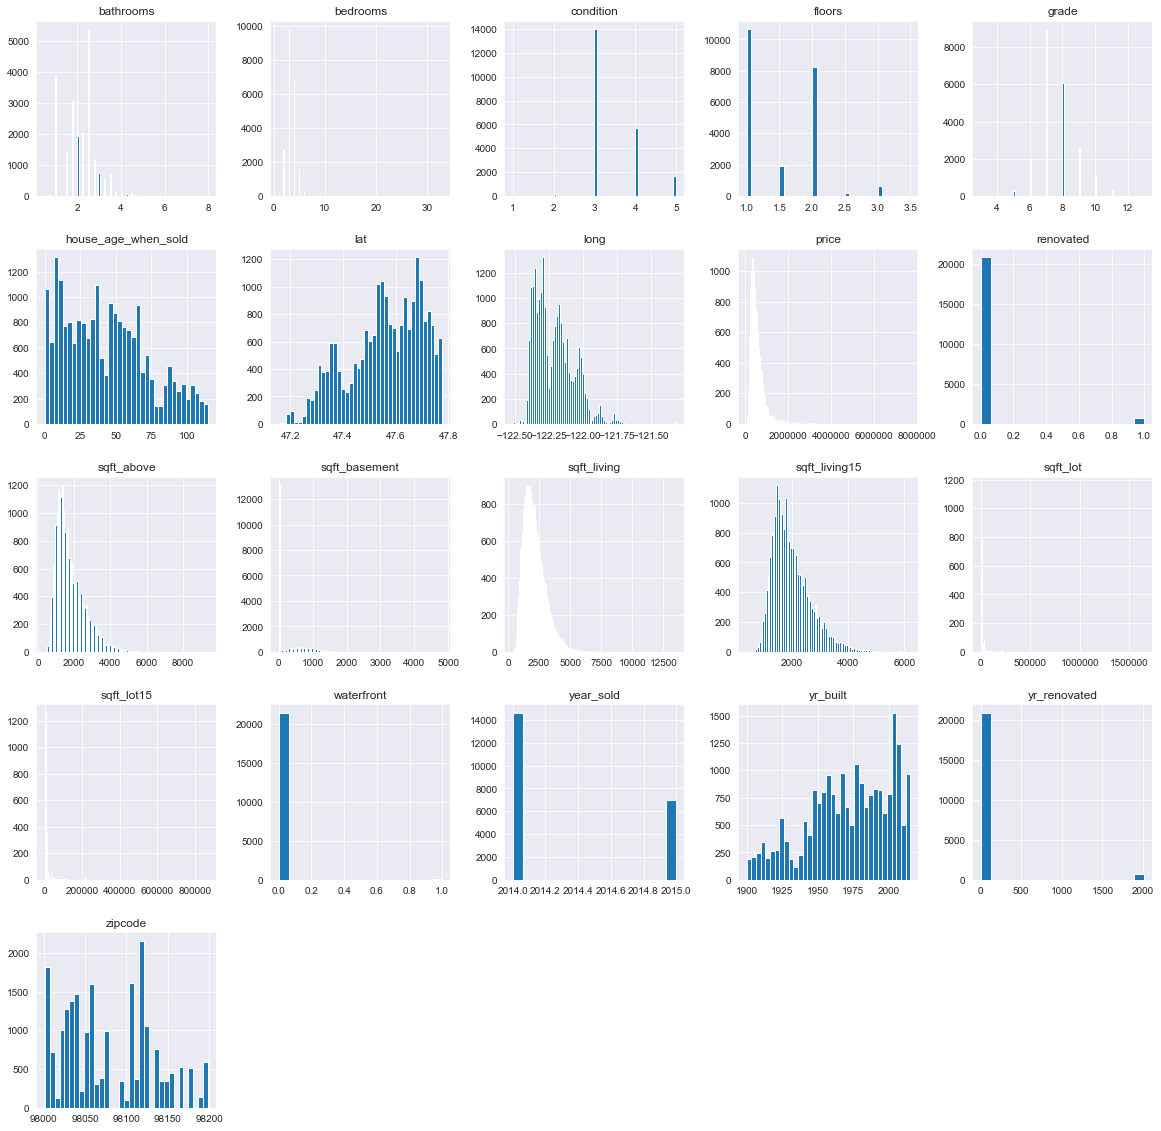

In [21]:
#CREATING HISTOGRAM OF ALL COLUMNS
df.hist(figsize = (20,20), bins = 'auto');

In [22]:
#DROPPING DATE COLUMN
# df.drop('date',axis =  1,inplace=True)

outliers_list = ['bedrooms','sqft_basement','sqft_above','sqft_living','sqft_lot','sqft_lot15','price']

#GETTING Z SCORES FOR ALL COLUMNS
z = np.abs(stats.zscore(df[outliers_list]))

#REMOVING OUTLIERS
df = df[(z<=1.96).all(axis=1)]
df

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold,renovated,house_age_when_sold,Sub_Region
0,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,2014,0,59,South_Urban
1,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,2014,1,63,Seattle
2,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,2015,0,82,North
3,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,2014,0,49,Seattle
4,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,2015,0,28,East_Urban
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,2014-05-21,360000.0,3,2.50,1530,1131,3.0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509,2014,0,5,Seattle
21593,2015-02-23,400000.0,4,2.50,2310,5813,2.0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200,2015,0,1,South_and_Seattle
21594,2014-06-23,402101.0,2,0.75,1020,1350,2.0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007,2014,0,5,Seattle
21595,2015-01-16,400000.0,3,2.50,1600,2388,2.0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287,2015,0,11,East_Urban


In [23]:
#TURNING SQFT BASEMENT COLUMN INTO BINARY (CONTAINS BASEMENT OR NOT)
df['has_basement'] = 0
for index,basement in enumerate(df['sqft_basement']):
    if basement > 0:
        df['has_basement'][index] = 1
df.drop('sqft_basement',axis = 1, inplace = True)

C:\Users\Biel_\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Biel_\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Biel_\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

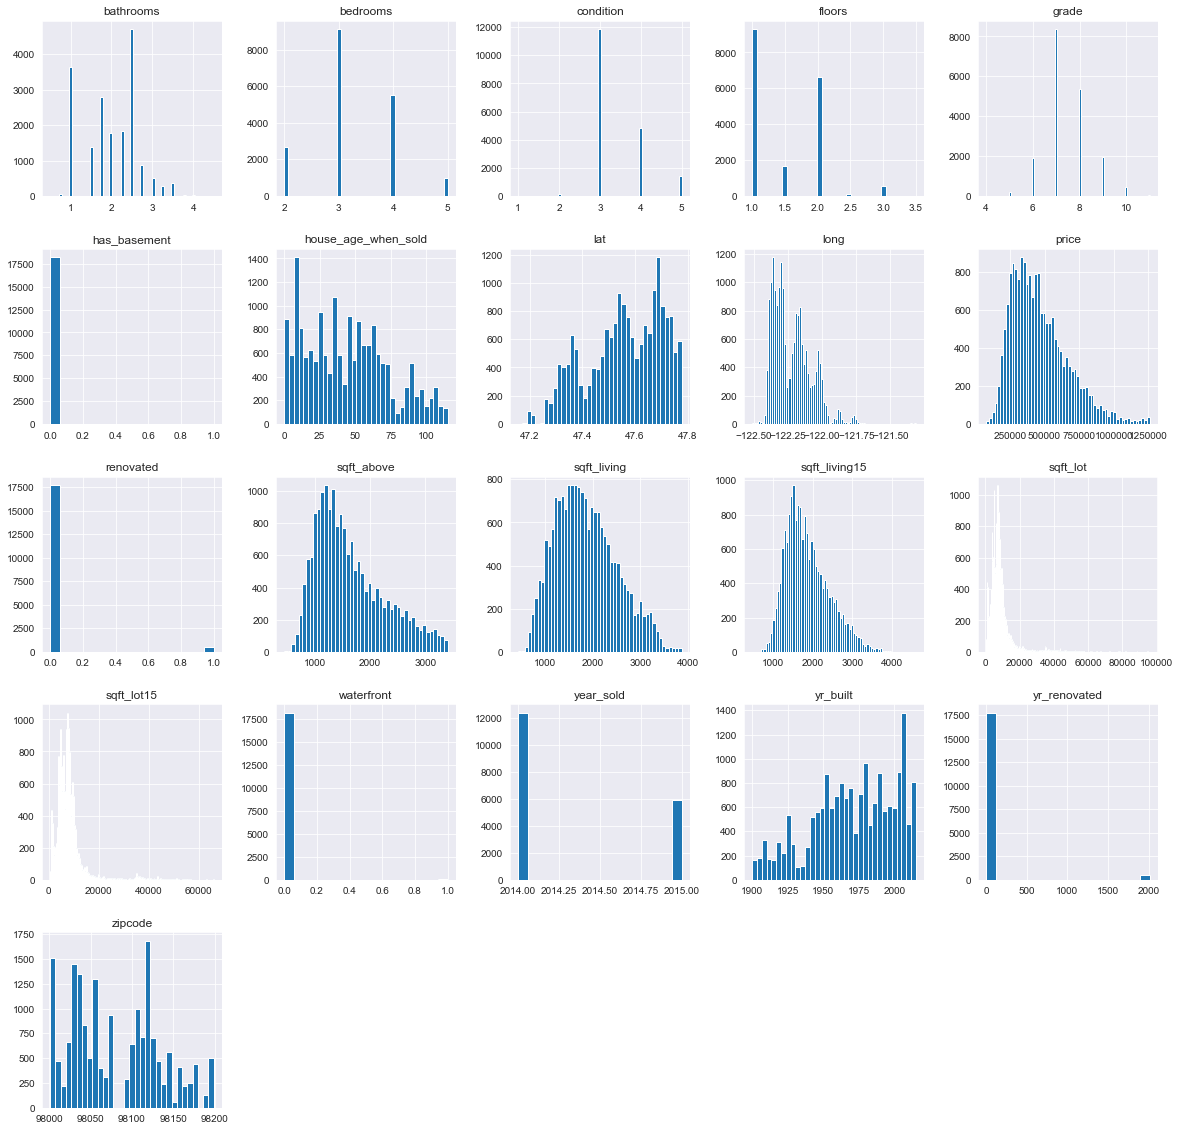

In [24]:
df.hist(figsize = (20,20), bins = 'auto');

In [25]:
#TURNING COLUMNS TO STRING FOR HOT ENCODING
categories = ['Sub_Region','waterfront','zipcode']
for cat in categories:
    df[cat] = df[cat].astype(str)
categories = ['Sub_Region','waterfront']
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 18280 entries, 0 to 21596
Data columns (total 23 columns):
date                   18280 non-null datetime64[ns]
price                  18280 non-null float64
bedrooms               18280 non-null int64
bathrooms              18280 non-null float64
sqft_living            18280 non-null int64
sqft_lot               18280 non-null int64
floors                 18280 non-null float64
waterfront             18280 non-null object
condition              18280 non-null int64
grade                  18280 non-null int64
sqft_above             18280 non-null int64
yr_built               18280 non-null int64
yr_renovated           18280 non-null int32
zipcode                18280 non-null object
lat                    18280 non-null float64
long                   18280 non-null float64
sqft_living15          18280 non-null int64
sqft_lot15             18280 non-null int64
year_sold              18280 non-null int64
renovated              18280 non-n

C:\Users\Biel_\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


# EXPLORE

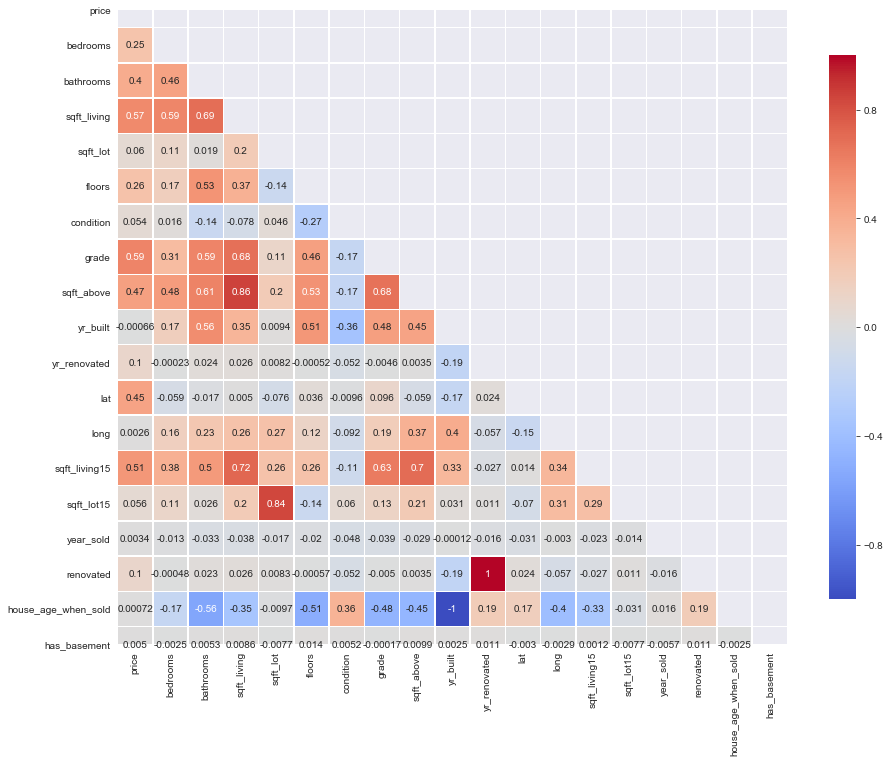

In [26]:
#CORRELATION HEATMAP
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(15, 20))

sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1, center=0,
            square=True, linewidths=.5,annot=True, cbar_kws={"shrink": .5});

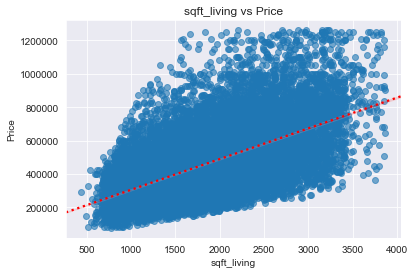

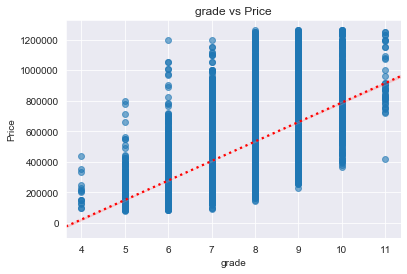

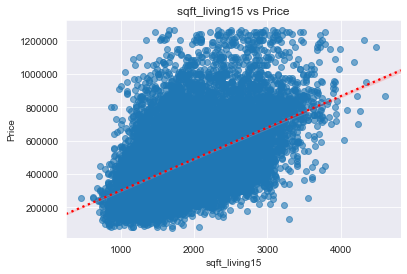

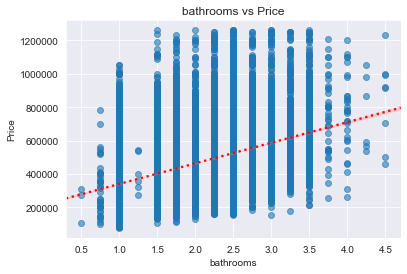

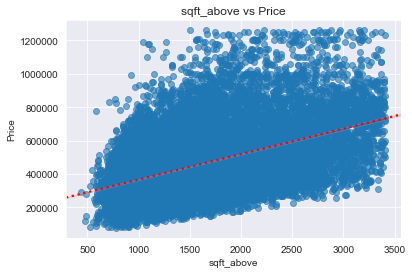

In [136]:
#CREATING SCATTER PLOT WITH TOP 5 CORRELATED COLUMNS WITH PRICE
top_5_cols = ['sqft_living','grade','sqft_living15','bathrooms','sqft_above']
for col in top_5_cols:

    figure = plt.figure
    ax = plt.gca()
    sns.regplot(col,'price',df,ax=ax,scatter_kws=dict(alpha=0.6),line_kws={'color':'red', 'ls':':'})
    ax.set_xlabel(col)
    ax.set_ylabel('Price')
    ax.set_title("{} vs {}".format(col, 'Price'))

    plt.show()

# BASE MODEL

In [28]:
#DEFINING TARGET AND PREDICTORS
y = 'price'
df_predictors_1 = df[top_5_cols]
X_1 = list(df_predictors_1.columns)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(df[X_1], df[y], test_size=0.25, random_state=69)
print(len(X_train), len(X_test), len(y_train), len(y_test))

13710 4570 13710 4570


In [30]:
train_df = pd.concat([y_train,X_train],axis=1)
test_df = pd.concat([y_test,X_test],axis=1)

In [31]:
#FITTING MODEL
predictors = '+'.join(X_train.columns)
formula = y + '~' + predictors
model_1 = ols(formula=formula, data=train_df).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.431
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                     2074.
Date:                Sun, 02 Aug 2020   Prob (F-statistic):               0.00
Time:                        16:31:58   Log-Likelihood:            -1.8322e+05
No. Observations:               13710   AIC:                         3.665e+05
Df Residuals:                   13704   BIC:                         3.665e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      -3.86e+05   1.15e+04    -33.591      0.000   -4.08e+05   -3.63e+05
sqft_living     159.8723      4.675     34.196      0.000     150.708     169.036
grade          9.045e+04   2059.953     43.907      0.000    8.64e+04    9.45e+04
sqft_living15    43.5636      3.633     11.991      0.000      36.443      50.685
bathrooms     -2.794e+04   2832.784     -9.862      0.000   -3.35e+04   -2.24e+04
sqft_above      -90.2157      4.265    -21.151      0.000     -98.576     -81.855
==============================================================================
Omnibus:                     1231.426   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1767.652
Skew:                           0.717   Prob(JB):                         0.00
Kurtosis:                       4.019   Cond. No.                     2.86e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.86e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

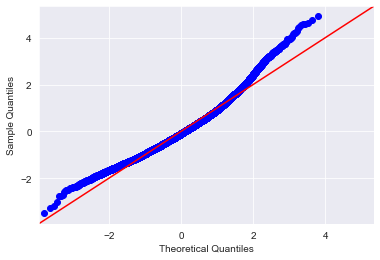

In [32]:
#CHECKING IF RESIDUALS ARE NORMALLY DISTRIBUTED
fig = sm.graphics.qqplot(model_1.resid, dist=stats.norm, line='45', fit=True)

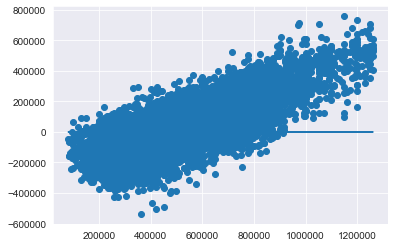

In [33]:
#CHECKING FOR HOMOSCEDACITY
plt.scatter(train_df['price'],model_1.resid)
plt.plot(train_df['price'], [0 for i in range(len(train_df))])

**ANALYSIS**

This base model, which used the top 5 features correlated with price, is only able to explain 43% of variability in price. It is a good starting point to be able to make improvements.


# MODEL 2 WITH ALL COLUMNS EXCEPT DATE,ZIPCODE, LAT,LONG

In [34]:
#HOT ENCODING
dummies = pd.get_dummies(df[categories],prefix = categories,drop_first = True)
df_preprocessed_2 = df.drop(categories,axis = 1)
df_preprocessed_2 = pd.concat([df_preprocessed_2,dummies],axis = 1)
df_preprocessed_2

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold,renovated,house_age_when_sold,has_basement,Sub_Region_East_Urban,Sub_Region_North,Sub_Region_North_and_Seattle,Sub_Region_Seattle,Sub_Region_South_Rural,Sub_Region_South_Urban,Sub_Region_South_and_Seattle,Sub_Region_Vashon_Island,Sub_Region_West,waterfront_1
0,2014-10-13,221900.0,3,1.00,1180,5650,1.0,3,7,1180,1955,0,98178,47.5112,-122.257,1340,5650,2014,0,59,0,0,0,0,0,0,1,0,0,0,0
1,2014-12-09,538000.0,3,2.25,2570,7242,2.0,3,7,2170,1951,1991,98125,47.7210,-122.319,1690,7639,2014,1,63,1,0,0,0,1,0,0,0,0,0,0
2,2015-02-25,180000.0,2,1.00,770,10000,1.0,3,6,770,1933,0,98028,47.7379,-122.233,2720,8062,2015,0,82,0,0,1,0,0,0,0,0,0,0,0
3,2014-12-09,604000.0,4,3.00,1960,5000,1.0,5,7,1050,1965,0,98136,47.5208,-122.393,1360,5000,2014,0,49,1,0,0,0,1,0,0,0,0,0,0
4,2015-02-18,510000.0,3,2.00,1680,8080,1.0,3,8,1680,1987,0,98074,47.6168,-122.045,1800,7503,2015,0,28,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,2014-05-21,360000.0,3,2.50,1530,1131,3.0,3,8,1530,2009,0,98103,47.6993,-122.346,1530,1509,2014,0,5,0,0,0,0,1,0,0,0,0,0,0
21593,2015-02-23,400000.0,4,2.50,2310,5813,2.0,3,8,2310,2014,0,98146,47.5107,-122.362,1830,7200,2015,0,1,0,0,0,0,0,0,0,1,0,0,0
21594,2014-06-23,402101.0,2,0.75,1020,1350,2.0,3,7,1020,2009,0,98144,47.5944,-122.299,1020,2007,2014,0,5,0,0,0,0,1,0,0,0,0,0,0
21595,2015-01-16,400000.0,3,2.50,1600,2388,2.0,3,8,1600,2004,0,98027,47.5345,-122.069,1410,1287,2015,0,11,0,1,0,0,0,0,0,0,0,0,0


In [35]:
#DEFINING TARGET AND PREDICTORS
y = 'price'
df_predictors_2 = df_preprocessed_2.drop(['price','date','zipcode','lat','long'],axis = 1)
X_2 = list(df_predictors_2.columns)

In [36]:
#TEST TRAIN SPLIT
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df_preprocessed_2[X_2], df_preprocessed_2[y], test_size=0.25, random_state=69)
print(len(X_train_2), len(X_test_2), len(y_train_2), len(y_test_2))

13710 4570 13710 4570


In [37]:
#COMBINING XTRAIN YTRAIN AND XTEST YTEST
train_df_2 = pd.concat([y_train_2,X_train_2],axis=1)
test_df_2 = pd.concat([y_test_2,X_test_2],axis=1)

In [38]:
#FITTING MODEL
predictors_2 = '+'.join(X_train_2.columns)
formula = y + '~' + predictors_2
model_2 = ols(formula=formula, data=train_df_2).fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     1442.
Date:                Sun, 02 Aug 2020   Prob (F-statistic):               0.00
Time:                        16:31:59   Log-Likelihood:            -1.7824e+05
No. Observations:               13710   AIC:                         3.565e+05
Df Residuals:                   13684   BIC:                         3.567e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                    -4.547e+07   3.96e+06    -11.481      0.000   -5.32e+07   -3.77e+07
bedrooms                       -1.2e+04   1535.749     -7.816      0.000    -1.5e+04   -8993.351
bathrooms                     1.583e+04   2367.275      6.686      0.000    1.12e+04    2.05e+04
sqft_living                     95.6549      3.838     24.924      0.000      88.132     103.177
sqft_lot                         1.0545      0.190      5.558      0.000       0.683       1.426
floors                        1.147e+04   2613.552      4.390      0.000    6351.310    1.66e+04
condition                     2.703e+04   1590.920     16.989      0.000    2.39e+04    3.01e+04
grade                         6.732e+04   1583.601     42.509      0.000    6.42e+04    7.04e+04
sqft_above                       2.2142      3.652      0.606      0.544      -4.944       9.373
yr_built                      6925.6113    655.986     10.558      0.000    5639.789    8211.433
yr_renovated                  1927.7870    337.863      5.706      0.000    1265.528    2590.046
sqft_living15                   56.2815      2.684     20.968      0.000      51.020      61.543
sqft_lot15                      -1.1862      0.239     -4.966      0.000      -1.654      -0.718
year_sold                     1.538e+04   1310.150     11.740      0.000    1.28e+04    1.79e+04
renovated                    -3.801e+06   6.74e+05     -5.638      0.000   -5.12e+06   -2.48e+06
house_age_when_sold           8456.1604    655.173     12.907      0.000    7171.931    9740.389
has_basement                  5.503e+04   2.77e+04      1.986      0.047     705.348    1.09e+05
Sub_Region_East_Urban         1.092e+05   5112.789     21.363      0.000    9.92e+04    1.19e+05
Sub_Region_North              1.486e+04   6069.176      2.448      0.014    2960.400    2.68e+04
Sub_Region_North_and_Seattle  3.368e+04   6873.989      4.899      0.000    2.02e+04    4.72e+04
Sub_Region_Seattle            1.245e+05   5507.481     22.602      0.000    1.14e+05    1.35e+05
Sub_Region_South_Rural       -7.848e+04   6523.407    -12.030      0.000   -9.13e+04   -6.57e+04
Sub_Region_South_Urban       -9.544e+04   5063.576    -18.847      0.000   -1.05e+05   -8.55e+04
Sub_Region_South_and_Seattle -9586.8349   8954.969     -1.071      0.284   -2.71e+04    7966.134
Sub_Region_Vashon_Island     -2.508e+04   1.87e+04     -1.344      0.179   -6.17e+04    1.15e+04
Sub_Region_West               1.356e+04   1.29e+04      1.049      0.294   -1.18e+04    3.89e+04
waterfront_1                  2.316e+05   1.54e+04     15.060      0.000    2.01e+05    2.62e+05
==============================================================================
Omnibus:                     1959.312   Durbin-Watson:                   2.004
Prob(Omnibus): 

In [39]:
#REMOVING FEATURES WITH P-VALUE > 0.05
summary_2 = model_2.summary()
p_table_2 = summary_2.tables[1]
p_table_2 = pd.DataFrame(p_table_2.data)
p_table_2.columns = p_table_2.iloc[0]
p_table_2 = p_table_2.drop(0)
p_table_2 = p_table_2.set_index(p_table_2.columns[0])
p_table_2['P>|t|'] = p_table_2['P>|t|'].astype(float)
x_cols_2 = list(p_table_2[p_table_2['P>|t|'] < 0.05].index)
x_cols_2.remove('Intercept')
print(len(p_table_2), len(x_cols_2))

27 22


In [40]:
#FITTING REVISED MODEL
predictors_2 = '+'.join(x_cols_2)
formula = y + '~' + predictors_2
model_2 = ols(formula=formula, data=train_df_2).fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     1716.
Date:                Sun, 02 Aug 2020   Prob (F-statistic):               0.00
Time:                        16:31:59   Log-Likelihood:            -1.7824e+05
No. Observations:               13710   AIC:                         3.565e+05
Df Residuals:                   13688   BIC:                         3.567e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                    -4.541e+07   3.96e+06    -11.468      0.000   -5.32e+07   -3.77e+07
bedrooms                     -1.197e+04   1535.353     -7.798      0.000    -1.5e+04   -8962.557
bathrooms                     1.546e+04   2311.495      6.689      0.000    1.09e+04       2e+04
sqft_living                     97.1047      2.910     33.369      0.000      91.401     102.809
sqft_lot                         1.0518      0.189      5.552      0.000       0.680       1.423
floors                        1.225e+04   2276.143      5.381      0.000    7786.080    1.67e+04
condition                     2.695e+04   1584.437     17.012      0.000    2.38e+04    3.01e+04
grade                         6.747e+04   1568.025     43.027      0.000    6.44e+04    7.05e+04
yr_built                      6917.7966    655.980     10.546      0.000    5631.986    8203.607
yr_renovated                  1928.6374    337.828      5.709      0.000    1266.448    2590.827
sqft_living15                   56.8857      2.653     21.438      0.000      51.685      62.087
sqft_lot15                      -1.1495      0.238     -4.837      0.000      -1.615      -0.684
year_sold                     1.536e+04   1310.085     11.725      0.000    1.28e+04    1.79e+04
renovated                    -3.803e+06   6.74e+05     -5.641      0.000   -5.12e+06   -2.48e+06
house_age_when_sold           8443.0809    655.103     12.888      0.000    7158.989    9727.173
has_basement                  5.485e+04   2.77e+04      1.979      0.048     532.255    1.09e+05
Sub_Region_East_Urban         1.111e+05   4236.738     26.229      0.000    1.03e+05    1.19e+05
Sub_Region_North              1.674e+04   5311.456      3.152      0.002    6329.053    2.72e+04
Sub_Region_North_and_Seattle   3.57e+04   6166.150      5.790      0.000    2.36e+04    4.78e+04
Sub_Region_Seattle            1.264e+05   4479.863     28.223      0.000    1.18e+05    1.35e+05
Sub_Region_South_Rural        -7.63e+04   5893.583    -12.946      0.000   -8.79e+04   -6.47e+04
Sub_Region_South_Urban       -9.329e+04   4150.572    -22.476      0.000   -1.01e+05   -8.52e+04
waterfront_1                  2.269e+05   1.51e+04     14.998      0.000    1.97e+05    2.57e+05
==============================================================================
Omnibus:                     1950.350   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5582.484
Skew:                           0.765   Prob(JB):                         0.00
Kurtosis:                       5.726   Cond. No.                     4.83e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is corre

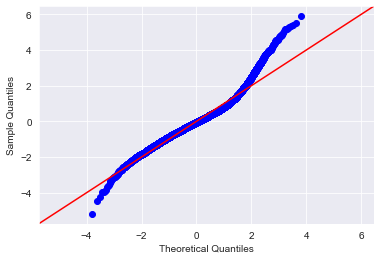

In [41]:
#CHECKING IF RESIDUALS ARE NORMALLY DISTRIBUTED
fig = sm.graphics.qqplot(model_2.resid, dist=stats.norm, line='45', fit=True)

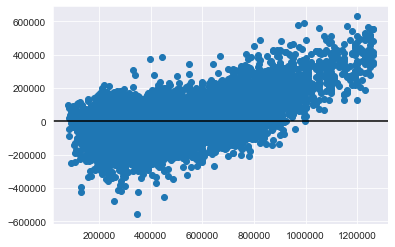

In [42]:
#CHECKING FOR HOMOSCEDACITY
plt.scatter(train_df_2['price'],model_2.resid)
plt.axhline(0,color='black')

**ANALYSIS**

By adding more features to the model, the R^2 value increased to 0.725, which means it can explain 72.5% of variability in house prices. With the extra features, it became more complex and it is fairly difficult to interpret which features are the most important because the data isn't scaled.

# MODEL 3 - DROPPING MULTICOLINEAR COLUMNS (CORR>0.75)

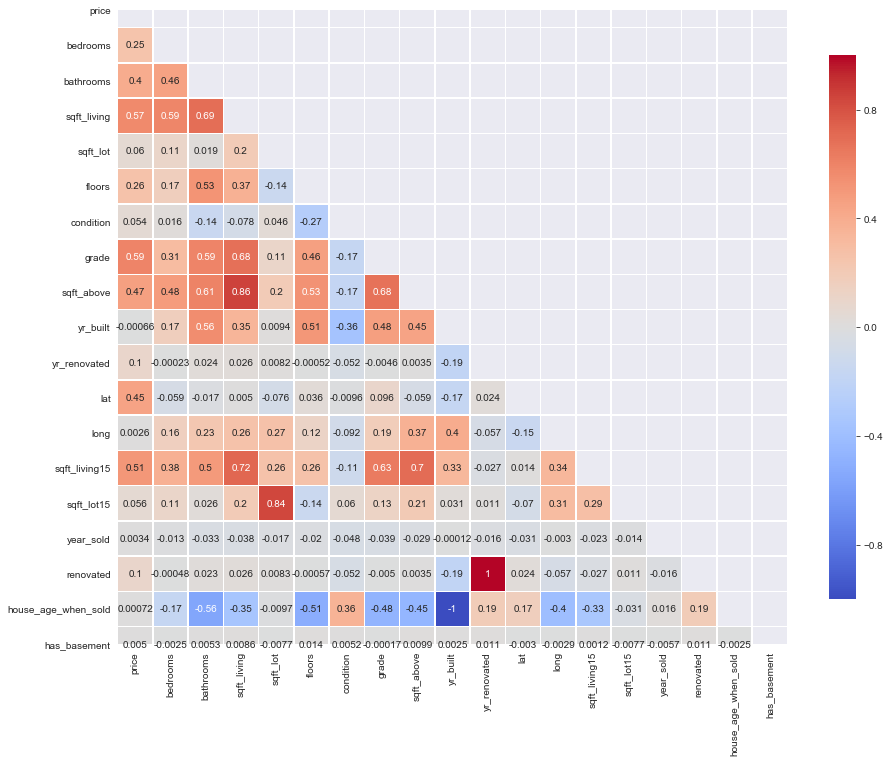

In [43]:
#CORRELATION HEATMAP
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(15, 20))

sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1, center=0,
            square=True, linewidths=.5,annot=True, cbar_kws={"shrink": .5});

In [44]:
#DROPPING COLUMNS NOT BEING USED IN MODEL
model3_df = df.drop(['lat','long','zipcode','date'],axis = 1)

#DROPPING COLUMNS WITH HIGH CORRELATION
model3_df = model3_df.drop(['sqft_above','yr_renovated','yr_built','sqft_lot15','sqft_living15'],axis = 1)

#STARDADIZING DATA EXCEPT TARGET (PRICE)
for col in model3_df.drop(['Sub_Region','waterfront','price'],axis=1).columns:
    model3_df[col] = stats.zscore(model3_df[col])


model3_df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,year_sold,renovated,house_age_when_sold,Sub_Region,has_basement
0,221900.0,-0.341654,-1.499279,-1.064684,-0.381525,-0.883860,0,-0.631690,-0.482946,-0.691122,-0.174802,0.508349,South_Urban,-0.036258
1,538000.0,-0.341654,0.380037,1.111125,-0.208878,0.962544,0,-0.631690,-0.482946,-0.691122,5.720746,0.644174,Seattle,27.580186
2,180000.0,-1.644416,-1.499279,-1.706469,0.090216,-0.883860,0,-0.631690,-1.526350,1.446923,-0.174802,1.289346,North,-0.036258
3,604000.0,0.961108,1.507627,0.156274,-0.452015,-0.883860,0,2.464513,-0.482946,-0.691122,-0.174802,0.168785,Seattle,27.580186
4,510000.0,-0.341654,0.004174,-0.282019,-0.118000,-0.883860,0,-0.631690,0.560459,1.446923,-0.174802,-0.544300,East_Urban,-0.036258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,-0.341654,0.755900,-0.516818,-0.871593,2.808948,0,-0.631690,0.560459,-0.691122,-0.174802,-1.325298,Seattle,-0.036258
21593,400000.0,0.961108,0.755900,0.704139,-0.363848,0.962544,0,-0.631690,0.560459,1.446923,-0.174802,-1.461123,South_and_Seattle,-0.036258
21594,402101.0,-1.644416,-1.875142,-1.315137,-0.847843,0.962544,0,-0.631690,-0.482946,-0.691122,-0.174802,-1.325298,Seattle,-0.036258
21595,400000.0,-0.341654,0.755900,-0.407245,-0.735276,0.962544,0,-0.631690,0.560459,1.446923,-0.174802,-1.121559,East_Urban,-0.036258


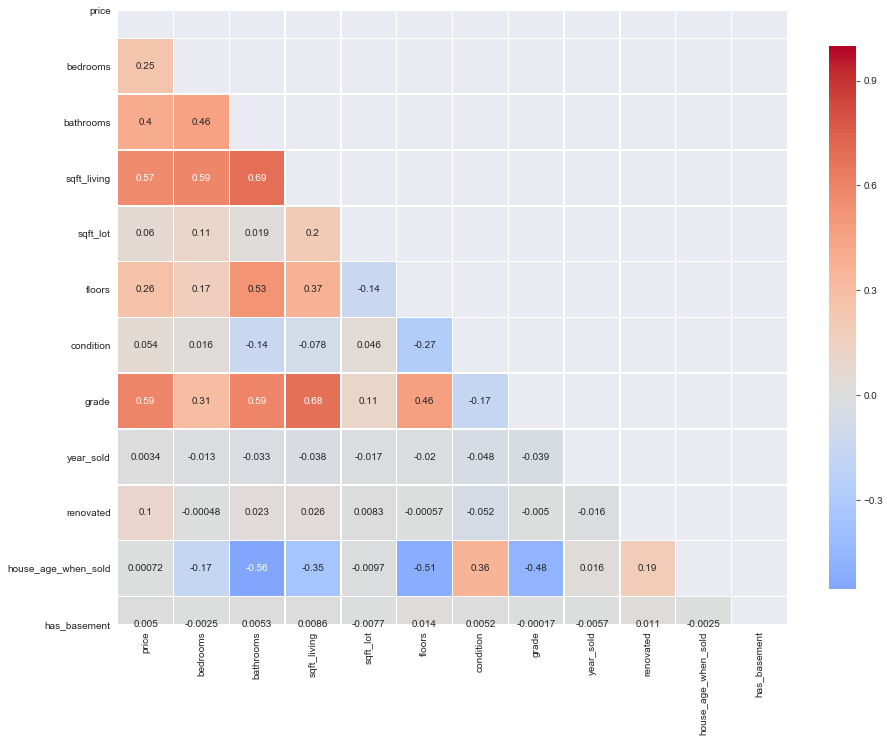

In [45]:
#CORRELATION HEATMAP
corr = model3_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(15, 20))

sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1, center=0,
            square=True, linewidths=.5,annot=True, cbar_kws={"shrink": .5});

In [46]:
#HOT ENCODING
dummies = pd.get_dummies(model3_df[categories],prefix = categories,drop_first = True)
df_preprocessed_3 = model3_df.drop(categories,axis = 1)
df_preprocessed_3 = pd.concat([df_preprocessed_3,dummies],axis = 1)
df_preprocessed_3

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,year_sold,renovated,house_age_when_sold,has_basement,Sub_Region_East_Urban,Sub_Region_North,Sub_Region_North_and_Seattle,Sub_Region_Seattle,Sub_Region_South_Rural,Sub_Region_South_Urban,Sub_Region_South_and_Seattle,Sub_Region_Vashon_Island,Sub_Region_West,waterfront_1
0,221900.0,-0.341654,-1.499279,-1.064684,-0.381525,-0.883860,-0.631690,-0.482946,-0.691122,-0.174802,0.508349,-0.036258,0,0,0,0,0,1,0,0,0,0
1,538000.0,-0.341654,0.380037,1.111125,-0.208878,0.962544,-0.631690,-0.482946,-0.691122,5.720746,0.644174,27.580186,0,0,0,1,0,0,0,0,0,0
2,180000.0,-1.644416,-1.499279,-1.706469,0.090216,-0.883860,-0.631690,-1.526350,1.446923,-0.174802,1.289346,-0.036258,0,1,0,0,0,0,0,0,0,0
3,604000.0,0.961108,1.507627,0.156274,-0.452015,-0.883860,2.464513,-0.482946,-0.691122,-0.174802,0.168785,27.580186,0,0,0,1,0,0,0,0,0,0
4,510000.0,-0.341654,0.004174,-0.282019,-0.118000,-0.883860,-0.631690,0.560459,1.446923,-0.174802,-0.544300,-0.036258,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,-0.341654,0.755900,-0.516818,-0.871593,2.808948,-0.631690,0.560459,-0.691122,-0.174802,-1.325298,-0.036258,0,0,0,1,0,0,0,0,0,0
21593,400000.0,0.961108,0.755900,0.704139,-0.363848,0.962544,-0.631690,0.560459,1.446923,-0.174802,-1.461123,-0.036258,0,0,0,0,0,0,1,0,0,0
21594,402101.0,-1.644416,-1.875142,-1.315137,-0.847843,0.962544,-0.631690,-0.482946,-0.691122,-0.174802,-1.325298,-0.036258,0,0,0,1,0,0,0,0,0,0
21595,400000.0,-0.341654,0.755900,-0.407245,-0.735276,0.962544,-0.631690,0.560459,1.446923,-0.174802,-1.121559,-0.036258,1,0,0,0,0,0,0,0,0,0


In [47]:
#DEFINING TARGET AND PREDICTORS
y = 'price'
df_predictors_3 = df_preprocessed_3.drop('price',axis = 1)
X_3 = list(df_predictors_3.columns)

In [48]:
#TEST-TRAIN SPLIT
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(df_preprocessed_3[X_3], df_preprocessed_3[y], test_size=0.25, random_state=69)
print(len(X_train_3), len(X_test_3), len(y_train_3), len(y_test_3))

13710 4570 13710 4570


In [49]:
#COMBINING XTRAIN YTRAIN AND XTEST YTEST
train_df_3 = pd.concat([y_train_3,X_train_3],axis=1)
test_df_3 = pd.concat([y_test_3,X_test_3],axis=1)

In [50]:
#FITTING MODEL
predictors_3 = '+'.join(X_train_3.columns)
formula = y + '~' + predictors_3
model_3 = ols(formula=formula, data=train_df_3).fit()
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     1636.
Date:                Sun, 02 Aug 2020   Prob (F-statistic):               0.00
Time:                        16:32:02   Log-Likelihood:            -1.7848e+05
No. Observations:               13710   AIC:                         3.570e+05
Df Residuals:                   13688   BIC:                         3.572e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                     4.303e+05   4838.714     88.922      0.000    4.21e+05     4.4e+05
bedrooms                      -1.04e+04   1197.631     -8.687      0.000   -1.28e+04   -8056.223
bathrooms                     1.043e+04   1562.653      6.678      0.000    7371.915    1.35e+04
sqft_living                   7.791e+04   1724.158     45.185      0.000    7.45e+04    8.13e+04
sqft_lot                      4551.8582   1077.226      4.226      0.000    2440.347    6663.369
floors                        6214.6242   1251.913      4.964      0.000    3760.703    8668.546
condition                     1.512e+04   1036.877     14.585      0.000    1.31e+04    1.72e+04
grade                         7.345e+04   1469.758     49.972      0.000    7.06e+04    7.63e+04
year_sold                     1.056e+04    935.497     11.290      0.000    8728.346    1.24e+04
renovated                     6271.8765    983.619      6.376      0.000    4343.849    8199.904
house_age_when_sold           4.772e+04   1535.298     31.083      0.000    4.47e+04    5.07e+04
has_basement                  1965.6863   1020.993      1.925      0.054     -35.600    3966.973
Sub_Region_East_Urban         1.128e+05   5188.422     21.745      0.000    1.03e+05    1.23e+05
Sub_Region_North              1.293e+04   6152.524      2.101      0.036     867.242     2.5e+04
Sub_Region_North_and_Seattle  2.526e+04   6930.531      3.645      0.000    1.17e+04    3.88e+04
Sub_Region_Seattle            1.121e+05   5410.595     20.716      0.000    1.01e+05    1.23e+05
Sub_Region_South_Rural       -7.874e+04   6634.256    -11.869      0.000   -9.17e+04   -6.57e+04
Sub_Region_South_Urban       -9.947e+04   5127.157    -19.401      0.000    -1.1e+05   -8.94e+04
Sub_Region_South_and_Seattle -2.315e+04   9063.258     -2.555      0.011   -4.09e+04   -5387.309
Sub_Region_Vashon_Island     -4.043e+04    1.9e+04     -2.132      0.033   -7.76e+04   -3250.916
Sub_Region_West               1.219e+04   1.31e+04      0.930      0.352   -1.35e+04    3.79e+04
waterfront_1                  2.314e+05   1.56e+04     14.811      0.000    2.01e+05    2.62e+05
==============================================================================
Omnibus:                     1986.984   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5699.402
Skew:                           0.778   Prob(JB):                         0.00
Kurtosis:                       5.749   Cond. No.                         40.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [51]:
#REMOVING FEATURES WITH P-VALUE > 0.05
summary_3 = model_3.summary()
p_table_3 = summary_3.tables[1]
p_table_3 = pd.DataFrame(p_table_3.data)
p_table_3.columns = p_table_3.iloc[0]
p_table_3 = p_table_3.drop(0)
p_table_3 = p_table_3.set_index(p_table_3.columns[0])
p_table_3['P>|t|'] = p_table_3['P>|t|'].astype(float)
x_cols_3 = list(p_table_3[p_table_3['P>|t|'] < 0.05].index)
x_cols_3.remove('Intercept')
print(len(p_table_3), len(x_cols_3))

22 19


In [52]:
#FITTING REVISED MODEL
predictors_3 = '+'.join(x_cols_3)
formula = y + '~' + predictors_3
model_3 = ols(formula=formula, data=train_df_3).fit()
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     1807.
Date:                Sun, 02 Aug 2020   Prob (F-statistic):               0.00
Time:                        16:32:02   Log-Likelihood:            -1.7848e+05
No. Observations:               13710   AIC:                         3.570e+05
Df Residuals:                   13690   BIC:                         3.572e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                     4.317e+05   4547.730     94.932      0.000    4.23e+05    4.41e+05
bedrooms                     -1.041e+04   1197.738     -8.687      0.000   -1.28e+04   -8057.515
bathrooms                     1.038e+04   1562.476      6.641      0.000    7313.162    1.34e+04
sqft_living                    7.79e+04   1724.115     45.182      0.000    7.45e+04    8.13e+04
sqft_lot                      4694.4818   1064.936      4.408      0.000    2607.061    6781.902
floors                        6225.9032   1251.923      4.973      0.000    3771.963    8679.844
condition                     1.514e+04   1036.906     14.606      0.000    1.31e+04    1.72e+04
grade                         7.356e+04   1464.738     50.223      0.000    7.07e+04    7.64e+04
year_sold                     1.055e+04    935.576     11.280      0.000    8719.804    1.24e+04
renovated                     6275.6278    983.505      6.381      0.000    4347.824    8203.432
house_age_when_sold           4.771e+04   1535.199     31.078      0.000    4.47e+04    5.07e+04
Sub_Region_East_Urban         1.113e+05   4896.370     22.730      0.000    1.02e+05    1.21e+05
Sub_Region_North              1.135e+04   5909.123      1.920      0.055    -235.599    2.29e+04
Sub_Region_North_and_Seattle  2.386e+04   6735.003      3.543      0.000    1.07e+04    3.71e+04
Sub_Region_Seattle            1.107e+05   5176.073     21.389      0.000    1.01e+05    1.21e+05
Sub_Region_South_Rural       -8.027e+04   6430.991    -12.481      0.000   -9.29e+04   -6.77e+04
Sub_Region_South_Urban       -1.009e+05   4854.315    -20.793      0.000    -1.1e+05   -9.14e+04
Sub_Region_South_and_Seattle -2.461e+04   8922.297     -2.759      0.006   -4.21e+04   -7124.867
Sub_Region_Vashon_Island     -4.225e+04   1.89e+04     -2.239      0.025   -7.92e+04   -5266.810
waterfront_1                  2.312e+05   1.56e+04     14.800      0.000    2.01e+05    2.62e+05
==============================================================================
Omnibus:                     1979.659   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5665.346
Skew:                           0.776   Prob(JB):                         0.00
Kurtosis:                       5.740   Cond. No.                         39.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [53]:
#REMOVING SCIENTIFIC NOTATION
pd.set_option('display.float_format', lambda x: '%.5f' % x)

#GETTING COEF VALUES
model_3.params.sort_values()


Sub_Region_South_Urban         -100934.45164
Sub_Region_South_Rural          -80265.88988
Sub_Region_Vashon_Island        -42245.13925
Sub_Region_South_and_Seattle    -24613.79317
bedrooms                        -10405.24704
sqft_lot                          4694.48184
floors                            6225.90322
renovated                         6275.62783
bathrooms                        10375.82943
year_sold                        10553.66077
Sub_Region_North                 11347.09369
condition                        15144.79674
Sub_Region_North_and_Seattle     23861.78855
house_age_when_sold              47710.82956
grade                            73563.51930
sqft_living                      77898.50994
Sub_Region_Seattle              110713.60645
Sub_Region_East_Urban           111294.98876
waterfront_1                    231239.81387
Intercept                       431726.68735
dtype: float64

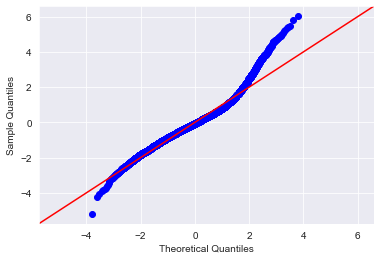

In [54]:
#CHECKING IF RESIDUALS ARE NORMALLY DISTRIBUTED
fig = sm.graphics.qqplot(model_3.resid, dist=stats.norm, line='45', fit=True)

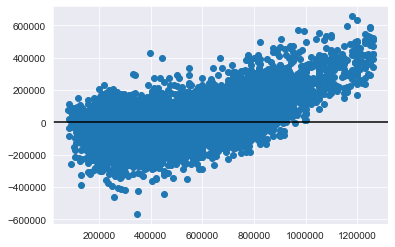

In [55]:
#CHECKING FOR HOMOSCEDACITY
plt.scatter(train_df_3['price'],model_3.resid)
plt.axhline(0,color='black')

In [56]:
#FITTING MODEL WITH TEST DATA
predictors_3 = '+'.join(X_train_3.columns)
formula = y + '~' + predictors_3
model_3_test = ols(formula=formula, data=test_df_3).fit()
model_3_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     547.8
Date:                Sun, 02 Aug 2020   Prob (F-statistic):               0.00
Time:                        16:32:02   Log-Likelihood:                -59599.
No. Observations:                4570   AIC:                         1.192e+05
Df Residuals:                    4548   BIC:                         1.194e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                     4.365e+05   9035.864     48.308      0.000    4.19e+05    4.54e+05
bedrooms                     -6458.1690   2113.350     -3.056      0.002   -1.06e+04   -2314.976
bathrooms                     1.134e+04   2776.224      4.084      0.000    5894.238    1.68e+04
sqft_living                   7.911e+04   3020.965     26.185      0.000    7.32e+04     8.5e+04
sqft_lot                      4230.6834   1832.663      2.308      0.021     637.774    7823.592
floors                        5133.6214   2280.216      2.251      0.024     663.290    9603.953
condition                      1.86e+04   1833.712     10.145      0.000     1.5e+04    2.22e+04
grade                         6.899e+04   2553.216     27.021      0.000     6.4e+04     7.4e+04
year_sold                     9445.2904   1661.762      5.684      0.000    6187.431    1.27e+04
renovated                     3876.7903   1719.420      2.255      0.024     505.892    7247.688
house_age_when_sold            4.29e+04   2758.128     15.553      0.000    3.75e+04    4.83e+04
has_basement                 -1859.0465   1355.222     -1.372      0.170   -4515.940     797.847
Sub_Region_East_Urban         1.087e+05   9670.529     11.235      0.000    8.97e+04    1.28e+05
Sub_Region_North              3833.3642   1.13e+04      0.338      0.735   -1.84e+04     2.6e+04
Sub_Region_North_and_Seattle  1.688e+04   1.25e+04      1.345      0.179   -7717.872    4.15e+04
Sub_Region_Seattle            1.125e+05   1.01e+04     11.180      0.000    9.27e+04    1.32e+05
Sub_Region_South_Rural       -9.378e+04   1.19e+04     -7.849      0.000   -1.17e+05   -7.04e+04
Sub_Region_South_Urban       -1.101e+05   9506.165    -11.582      0.000   -1.29e+05   -9.15e+04
Sub_Region_South_and_Seattle -2.083e+04   1.71e+04     -1.218      0.223   -5.44e+04    1.27e+04
Sub_Region_Vashon_Island      4279.6686   2.68e+04      0.159      0.873   -4.83e+04    5.69e+04
Sub_Region_West               2.206e+04   2.01e+04      1.097      0.273   -1.74e+04    6.15e+04
waterfront_1                  1.657e+05   2.79e+04      5.944      0.000    1.11e+05     2.2e+05
==============================================================================
Omnibus:                      943.722   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3451.278
Skew:                           0.999   Prob(JB):                         0.00
Kurtosis:                       6.760   Cond. No.                         36.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [57]:
#REMOVING FEATURES WITH P-VALUE > 0.05
summary_3_test = model_3_test.summary()
p_table_3_test = summary_3_test.tables[1]
p_table_3_test = pd.DataFrame(p_table_3_test.data)
p_table_3_test.columns = p_table_3_test.iloc[0]
p_table_3_test = p_table_3_test.drop(0)
p_table_3_test = p_table_3_test.set_index(p_table_3_test.columns[0])
p_table_3_test['P>|t|'] = p_table_3_test['P>|t|'].astype(float)
x_cols_3_test = list(p_table_3_test[p_table_3_test['P>|t|'] < 0.05].index)
x_cols_3_test.remove('Intercept')
print(len(p_table_3_test), len(x_cols_3_test))

22 15


In [58]:
#FITTING REVISED TEST MODEL
predictors_3_test = '+'.join(x_cols_3_test)
formula = y + '~' + predictors_3_test
model_3_test = ols(formula=formula, data=test_df_3).fit()
model_3_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     766.0
Date:                Sun, 02 Aug 2020   Prob (F-statistic):               0.00
Time:                        16:32:03   Log-Likelihood:                -59603.
No. Observations:                4570   AIC:                         1.192e+05
Df Residuals:                    4554   BIC:                         1.193e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               4.415e+05   4280.106    103.158      0.000    4.33e+05     4.5e+05
bedrooms               -6393.8458   2109.513     -3.031      0.002   -1.05e+04   -2258.178
bathrooms               1.128e+04   2775.611      4.063      0.000    5834.460    1.67e+04
sqft_living             7.874e+04   3014.781     26.117      0.000    7.28e+04    8.46e+04
sqft_lot                4499.5112   1761.559      2.554      0.011    1046.002    7953.021
floors                  4988.3016   2272.533      2.195      0.028     533.035    9443.568
condition               1.873e+04   1827.995     10.247      0.000    1.51e+04    2.23e+04
grade                   6.968e+04   2527.933     27.563      0.000    6.47e+04    7.46e+04
year_sold               9394.1494   1661.457      5.654      0.000    6136.888    1.27e+04
renovated               3796.4498   1718.642      2.209      0.027     427.077    7165.822
house_age_when_sold     4.294e+04   2737.723     15.684      0.000    3.76e+04    4.83e+04
Sub_Region_East_Urban   1.034e+05   5549.516     18.632      0.000    9.25e+04    1.14e+05
Sub_Region_Seattle      1.075e+05   5884.537     18.274      0.000     9.6e+04    1.19e+05
Sub_Region_South_Rural  -9.88e+04   9155.489    -10.792      0.000   -1.17e+05   -8.09e+04
Sub_Region_South_Urban -1.152e+05   5293.131    -21.759      0.000   -1.26e+05   -1.05e+05
waterfront_1            1.657e+05   2.73e+04      6.071      0.000    1.12e+05    2.19e+05
==============================================================================
Omnibus:                      935.094   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3425.513
Skew:                           0.989   Prob(JB):                         0.00
Kurtosis:                       6.752   Cond. No.                         30.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [59]:
#GETTING REVISED MODEL COEF
model_3_test.params.sort_values()

Sub_Region_South_Urban   -115172.80185
Sub_Region_South_Rural    -98804.27413
bedrooms                   -6393.84578
renovated                   3796.44977
sqft_lot                    4499.51124
floors                      4988.30160
year_sold                   9394.14940
bathrooms                  11276.00258
condition                  18730.64474
house_age_when_sold        42939.69640
grade                      69677.69530
sqft_living                78736.64759
Sub_Region_East_Urban     103401.33427
Sub_Region_Seattle        107532.66682
waterfront_1              165733.05354
Intercept                 441528.45258
dtype: float64

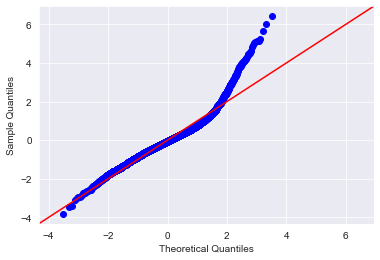

In [60]:
#CHECKING IF RESIDUALS ARE NORMALLY DISTRIBUTED
fig = sm.graphics.qqplot(model_3_test.resid, dist=stats.norm, line='45', fit=True)

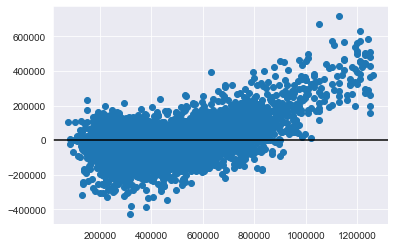

In [61]:
#CHECKING FOR HOMOSCEDACITY
plt.scatter(test_df_3['price'],model_3_test.resid)
plt.axhline(0,color='black')

**ANALYSIS**

By removing multicolinear columns,the R^2 value dropped by 1% to 71.5%, but by doing so, the model became simpler and the condition number dropped to an acceptable level.The test model confirmed the validity of the model, with both the train and test models varying by less than 1%. Also, by standardizing the data, it became easier to see which features have the highest impact with price, with them being located in the waterfront, in Seattle and in East Urban Regions, and having the highest living area. The residuals aren't completely normally distributed with the model having difficulties with high priced houses.

# 1 - WHICH CREATES A BETTER MODEL, ZIPCODES OR SUB REGIONS?

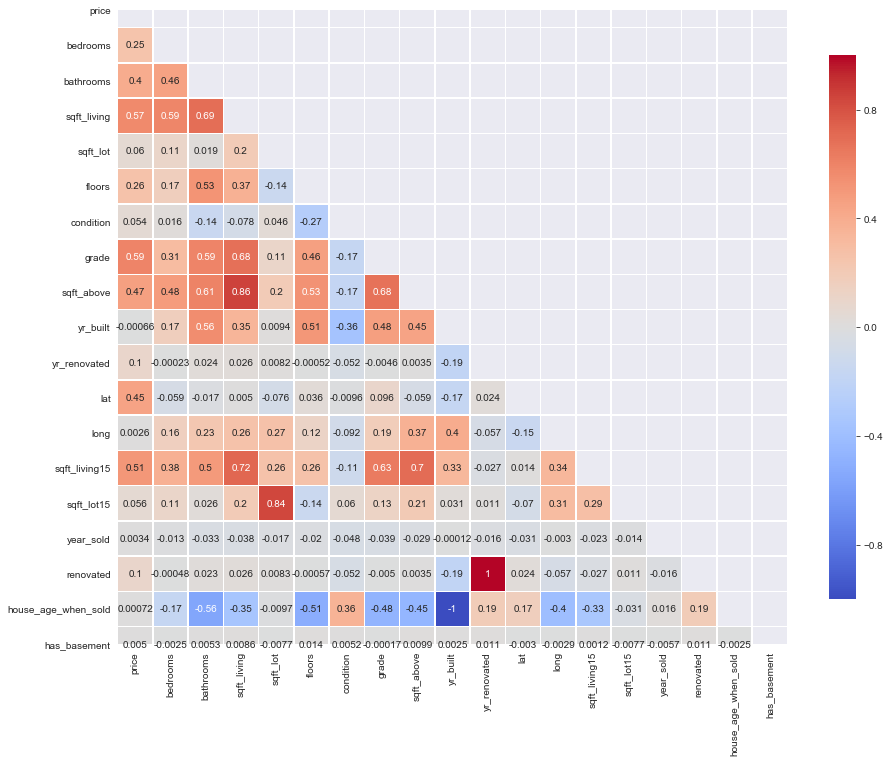

In [62]:
#CORRELATION HEATMAP
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(15, 20))

sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1, center=0,
            square=True, linewidths=.5,annot=True, cbar_kws={"shrink": .5});

In [63]:
#DROPPING COLUMNS NOT BEING USED IN MODEL
model6_df = df.drop(['lat','long','Sub_Region','date'],axis = 1)

#DROPPING COLUMNS WITH HIGH CORRELATION
model6_df = model6_df.drop(['sqft_above','yr_renovated','yr_built','sqft_lot15','sqft_living15'],axis = 1)

#STARDADIZING DATA EXCEPT TARGET (PRICE)
for col in model6_df.drop(['zipcode','waterfront','price'],axis=1).columns:
    model6_df[col] = stats.zscore(model6_df[col])
    
model6_df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,zipcode,year_sold,renovated,house_age_when_sold,has_basement
0,221900.00000,-0.34165,-1.49928,-1.06468,-0.38152,-0.88386,0,-0.63169,-0.48295,98178,-0.69112,-0.17480,0.50835,-0.03626
1,538000.00000,-0.34165,0.38004,1.11112,-0.20888,0.96254,0,-0.63169,-0.48295,98125,-0.69112,5.72075,0.64417,27.58019
2,180000.00000,-1.64442,-1.49928,-1.70647,0.09022,-0.88386,0,-0.63169,-1.52635,98028,1.44692,-0.17480,1.28935,-0.03626
3,604000.00000,0.96111,1.50763,0.15627,-0.45201,-0.88386,0,2.46451,-0.48295,98136,-0.69112,-0.17480,0.16878,27.58019
4,510000.00000,-0.34165,0.00417,-0.28202,-0.11800,-0.88386,0,-0.63169,0.56046,98074,1.44692,-0.17480,-0.54430,-0.03626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.00000,-0.34165,0.75590,-0.51682,-0.87159,2.80895,0,-0.63169,0.56046,98103,-0.69112,-0.17480,-1.32530,-0.03626
21593,400000.00000,0.96111,0.75590,0.70414,-0.36385,0.96254,0,-0.63169,0.56046,98146,1.44692,-0.17480,-1.46112,-0.03626
21594,402101.00000,-1.64442,-1.87514,-1.31514,-0.84784,0.96254,0,-0.63169,-0.48295,98144,-0.69112,-0.17480,-1.32530,-0.03626
21595,400000.00000,-0.34165,0.75590,-0.40725,-0.73528,0.96254,0,-0.63169,0.56046,98027,1.44692,-0.17480,-1.12156,-0.03626


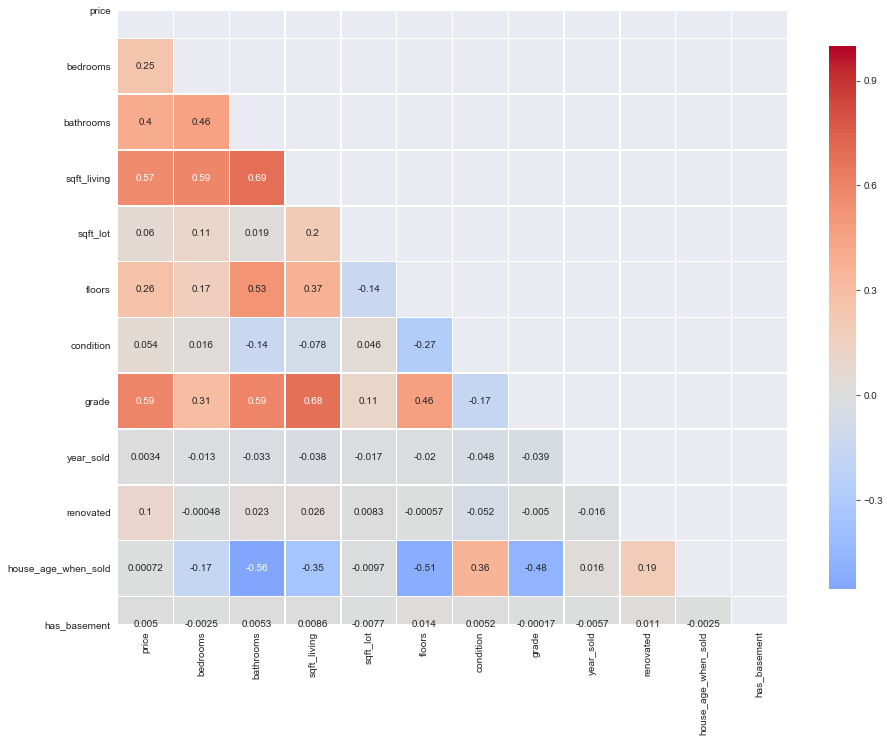

In [64]:
#CORRELATION HEATMAP
corr = model6_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(15, 20))

sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1, center=0,
            square=True, linewidths=.5,annot=True, cbar_kws={"shrink": .5});

In [65]:
# #TURNING COLUMNS TO STRING FOR HOT ENCODING
categories_2 = ['zipcode','waterfront']

#HOT ENCODING
dummies = pd.get_dummies(model6_df[categories_2],prefix = categories_2,drop_first = True)
df_preprocessed_6 = model6_df.drop(categories_2,axis = 1)
df_preprocessed_6 = pd.concat([df_preprocessed_6,dummies],axis = 1)
df_preprocessed_6

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,year_sold,renovated,house_age_when_sold,has_basement,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,...,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,waterfront_1
0,221900.00000,-0.34165,-1.49928,-1.06468,-0.38152,-0.88386,-0.63169,-0.48295,-0.69112,-0.17480,0.50835,-0.03626,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,538000.00000,-0.34165,0.38004,1.11112,-0.20888,0.96254,-0.63169,-0.48295,-0.69112,5.72075,0.64417,27.58019,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,180000.00000,-1.64442,-1.49928,-1.70647,0.09022,-0.88386,-0.63169,-1.52635,1.44692,-0.17480,1.28935,-0.03626,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,604000.00000,0.96111,1.50763,0.15627,-0.45201,-0.88386,2.46451,-0.48295,-0.69112,-0.17480,0.16878,27.58019,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,510000.00000,-0.34165,0.00417,-0.28202,-0.11800,-0.88386,-0.63169,0.56046,1.44692,-0.17480,-0.54430,-0.03626,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.00000,-0.34165,0.75590,-0.51682,-0.87159,2.80895,-0.63169,0.56046,-0.69112,-0.17480,-1.32530,-0.03626,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
21593,400000.00000,0.96111,0.75590,0.70414,-0.36385,0.96254,-0.63169,0.56046,1.44692,-0.17480,-1.46112,-0.03626,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
21594,402101.00000,-1.64442,-1.87514,-1.31514,-0.84784,0.96254,-0.63169,-0.48295,-0.69112,-0.17480,-1.32530,-0.03626,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
21595,400000.00000,-0.34165,0.75590,-0.40725,-0.73528,0.96254,-0.63169,0.56046,1.44692,-0.17480,-1.12156,-0.03626,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [66]:
#DEFINING TARGET AND PREDICTORS
y = 'price'
df_predictors_6 = df_preprocessed_6.drop('price',axis = 1)
X_6 = list(df_predictors_6.columns)

In [67]:
#TRAIN-TEST SPLIT
X_train_6, X_test_6, y_train_6, y_test_6 = train_test_split(df_preprocessed_6[X_6], df_preprocessed_6[y], test_size=0.25, random_state=69)
print(len(X_train_6), len(X_test_6), len(y_train_6), len(y_test_6))

13710 4570 13710 4570


In [68]:
#COMBINING XTRAIN YTRAIN AND XTEST YTEST
train_df_6 = pd.concat([y_train_6,X_train_6],axis=1)
test_df_6 = pd.concat([y_test_6,X_test_6],axis=1)

In [69]:
#FITTING MODEL
predictors_6 = '+'.join(X_train_6.columns)
formula = y + '~' + predictors_6
model_6 = ols(formula=formula, data=train_df_6).fit()
model_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     729.3
Date:                Sun, 02 Aug 2020   Prob (F-statistic):               0.00
Time:                        16:32:05   Log-Likelihood:            -1.7561e+05
No. Observations:               13710   AIC:                         3.514e+05
Df Residuals:                   13628   BIC:                         3.520e+05
Df Model:                          81                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            2.952e+05   5545.841     53.227      0.000    2.84e+05    3.06e+05
bedrooms            -6490.6703    985.348     -6.587      0.000   -8422.088   -4559.252
bathrooms            6129.5387   1280.994      4.785      0.000    3618.613    8640.465
sqft_living          8.327e+04   1430.710     58.201      0.000    8.05e+04    8.61e+04
sqft_lot             1.032e+04    912.911     11.306      0.000    8532.198    1.21e+04
floors               -306.9798   1054.991     -0.291      0.771   -2374.907    1760.947
condition            1.358e+04    862.728     15.736      0.000    1.19e+04    1.53e+04
grade                5.353e+04   1255.534     42.636      0.000    5.11e+04     5.6e+04
year_sold            1.175e+04    762.824     15.400      0.000    1.03e+04    1.32e+04
renovated            5994.3778    804.186      7.454      0.000    4418.061    7570.694
house_age_when_sold  2.223e+04   1330.284     16.708      0.000    1.96e+04    2.48e+04
has_basement         1044.5374    831.664      1.256      0.209    -585.638    2674.713
zipcode_98002        9414.9098   9212.548      1.022      0.307   -8642.957    2.75e+04
zipcode_98003       -2746.2051   8437.499     -0.325      0.745   -1.93e+04    1.38e+04
zipcode_98004        5.155e+05   9849.083     52.337      0.000    4.96e+05    5.35e+05
zipcode_98005        3.323e+05   1.08e+04     30.674      0.000    3.11e+05    3.53e+05
zipcode_98006        2.671e+05   8094.911     32.991      0.000    2.51e+05    2.83e+05
zipcode_98007        2.533e+05   1.09e+04     23.149      0.000    2.32e+05    2.75e+05
zipcode_98008        2.406e+05   8595.198     27.998      0.000    2.24e+05    2.57e+05
zipcode_98010        8.008e+04   1.36e+04      5.879      0.000    5.34e+04    1.07e+05
zipcode_98011        1.472e+05   9565.323     15.385      0.000    1.28e+05    1.66e+05
zipcode_98014        8.993e+04   1.36e+04      6.602      0.000    6.32e+04    1.17e+05
zipcode_98019        9.626e+04   1.01e+04      9.525      0.000    7.64e+04    1.16e+05
zipcode_98022        9433.4123   9558.595      0.987      0.324   -9302.754    2.82e+04
zipcode_98023       -1.953e+04   7288.504     -2.679      0.007   -3.38e+04   -5243.018
zipcode_98024        1.234e+05   1.77e+04      6.982      0.000    8.88e+04    1.58e+05
zipcode_98027        2.013e+05   8180.423     24.613      0.000    1.85e+05    2.17e+05
zipcode_98028        1.328e+05   8577.164     15.488      0.000    1.16e+05     1.5e+05
zipcode_98029        2.232e+05   8130.035     27.454      0.000    2.07e+05    2.39e+05
zipcode_98030        1175.0727   8723.561      0.135      0.893   -1.59e+04    1.83e+04
zipcode_98031        7396.3346   8522.454      0.868      0.385   -9308.852    2.41e+04
zipcode_98032        2744.9206   1.15e+04      0.239      0.811   -1.97e+04    2.52e+04
zip

In [70]:
#REMOVING FEATURES WITH P-VALUE > 0.05
summary_6 = model_6.summary()
p_table_6 = summary_6.tables[1]
p_table_6 = pd.DataFrame(p_table_6.data)
p_table_6.columns = p_table_6.iloc[0]
p_table_6 = p_table_6.drop(0)
p_table_6 = p_table_6.set_index(p_table_6.columns[0])
p_table_6['P>|t|'] = p_table_6['P>|t|'].astype(float)
x_cols_6 = list(p_table_6[p_table_6['P>|t|'] < 0.05].index)
x_cols_6.remove('Intercept')
print(len(p_table_6), len(x_cols_6))

82 72


In [71]:
#FTTING REVISED MODEL
predictors_6 = '+'.join(x_cols_6)
formula = y + '~' + predictors_6
model_6 = ols(formula=formula, data=train_df_6).fit()
model_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     820.6
Date:                Sun, 02 Aug 2020   Prob (F-statistic):               0.00
Time:                        16:32:06   Log-Likelihood:            -1.7561e+05
No. Observations:               13710   AIC:                         3.514e+05
Df Residuals:                   13637   BIC:                         3.519e+05
Df Model:                          72                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            2.997e+05   2337.025    128.261      0.000    2.95e+05    3.04e+05
bedrooms            -6486.4277    984.773     -6.587      0.000   -8416.719   -4556.136
bathrooms            6049.7879   1264.237      4.785      0.000    3571.708    8527.868
sqft_living          8.328e+04   1427.169     58.356      0.000    8.05e+04    8.61e+04
sqft_lot             1.033e+04    906.753     11.389      0.000    8549.562    1.21e+04
condition            1.372e+04    857.421     15.999      0.000     1.2e+04    1.54e+04
grade                5.338e+04   1246.179     42.837      0.000    5.09e+04    5.58e+04
year_sold            1.176e+04    762.561     15.419      0.000    1.03e+04    1.33e+04
renovated            6040.8876    802.097      7.531      0.000    4468.668    7613.108
house_age_when_sold  2.221e+04   1256.859     17.669      0.000    1.97e+04    2.47e+04
zipcode_98004        5.112e+05   8463.447     60.402      0.000    4.95e+05    5.28e+05
zipcode_98005        3.279e+05   9591.072     34.185      0.000    3.09e+05    3.47e+05
zipcode_98006        2.626e+05   6334.690     41.448      0.000     2.5e+05    2.75e+05
zipcode_98007        2.491e+05   9708.939     25.655      0.000     2.3e+05    2.68e+05
zipcode_98008        2.362e+05   6958.497     33.940      0.000    2.23e+05     2.5e+05
zipcode_98010        7.538e+04   1.27e+04      5.944      0.000    5.05e+04       1e+05
zipcode_98011        1.426e+05   8147.853     17.507      0.000    1.27e+05    1.59e+05
zipcode_98014        8.534e+04   1.27e+04      6.722      0.000    6.05e+04     1.1e+05
zipcode_98019        9.158e+04   8781.066     10.429      0.000    7.44e+04    1.09e+05
zipcode_98023       -2.395e+04   5277.341     -4.538      0.000   -3.43e+04   -1.36e+04
zipcode_98024        1.188e+05    1.7e+04      7.006      0.000    8.56e+04    1.52e+05
zipcode_98027        1.967e+05   6463.171     30.439      0.000    1.84e+05    2.09e+05
zipcode_98028        1.283e+05   6964.305     18.425      0.000    1.15e+05    1.42e+05
zipcode_98029        2.186e+05   6371.510     34.303      0.000    2.06e+05    2.31e+05
zipcode_98033        3.246e+05   6043.613     53.709      0.000    3.13e+05    3.36e+05
zipcode_98034        1.833e+05   5142.883     35.642      0.000    1.73e+05    1.93e+05
zipcode_98038        3.772e+04   5159.579      7.310      0.000    2.76e+04    4.78e+04
zipcode_98039         6.45e+05   3.63e+04     17.769      0.000    5.74e+05    7.16e+05
zipcode_98040         4.36e+05   9268.933     47.043      0.000    4.18e+05    4.54e+05
zipcode_98045        1.002e+05   7608.072     13.164      0.000    8.52e+04    1.15e+05
zipcode_98052         2.45e+05   5075.129     48.269      0.000    2.35e+05    2.55e+05
zipcode_98053        2.405e+05   6398.785     37.578      0.000    2.28e+05    2.53e+05
zip

In [72]:
#GETTING MODEL COEF
model_6.params.sort_values()

zipcode_98092   -25615.72703
zipcode_98023   -23949.09123
bedrooms         -6486.42772
renovated         6040.88760
bathrooms         6049.78794
                    ...     
zipcode_98109   413563.01274
zipcode_98112   434989.29079
zipcode_98040   436037.34817
zipcode_98004   511208.39484
zipcode_98039   645003.33110
Length: 73, dtype: float64

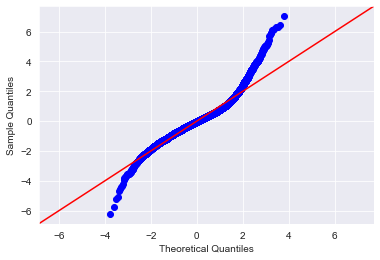

In [73]:
#CHECKING IF RESIDUALS ARE NORMALLY DISTRIBUTED
fig = sm.graphics.qqplot(model_6.resid, dist=stats.norm, line='45', fit=True)

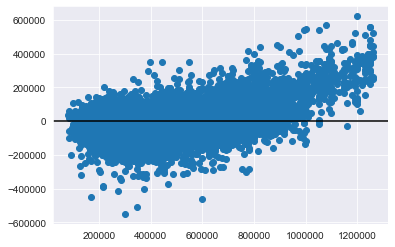

In [74]:
#CHECKING FOR HOMOSCEDACITY
plt.scatter(train_df_6['price'],model_6.resid)
plt.axhline(0,color='black')

In [75]:
#FITTING MODEL WITH TEST DATA
predictors_6 = '+'.join(X_train_6.columns)
formula = y + '~' + predictors_6
model_6_test = ols(formula=formula, data=test_df_6).fit()
model_6_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     256.7
Date:                Sun, 02 Aug 2020   Prob (F-statistic):               0.00
Time:                        16:32:07   Log-Likelihood:                -58531.
No. Observations:                4570   AIC:                         1.172e+05
Df Residuals:                    4488   BIC:                         1.178e+05
Df Model:                          81                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            2.898e+05      1e+04     28.976      0.000     2.7e+05    3.09e+05
bedrooms            -3772.2600   1712.727     -2.202      0.028   -7130.049    -414.471
bathrooms            7581.8173   2238.590      3.387      0.001    3193.077     1.2e+04
sqft_living          8.427e+04   2474.004     34.061      0.000    7.94e+04    8.91e+04
sqft_lot             8056.8657   1526.844      5.277      0.000    5063.499    1.11e+04
floors              -2521.1559   1897.214     -1.329      0.184   -6240.630    1198.319
condition            1.386e+04   1515.038      9.151      0.000    1.09e+04    1.68e+04
grade                5.076e+04   2121.058     23.930      0.000    4.66e+04    5.49e+04
year_sold            1.017e+04   1336.653      7.610      0.000    7550.986    1.28e+04
renovated            4049.5590   1384.302      2.925      0.003    1335.644    6763.474
house_age_when_sold   1.77e+04   2349.783      7.532      0.000    1.31e+04    2.23e+04
has_basement         -768.9554   1090.863     -0.705      0.481   -2907.584    1369.673
zipcode_98002        1.508e+04   1.73e+04      0.871      0.384   -1.89e+04     4.9e+04
zipcode_98003       -3442.4052   1.46e+04     -0.235      0.814   -3.22e+04    2.53e+04
zipcode_98004        6.144e+05    1.8e+04     34.205      0.000    5.79e+05     6.5e+05
zipcode_98005        3.201e+05   1.86e+04     17.253      0.000    2.84e+05    3.56e+05
zipcode_98006        2.759e+05   1.39e+04     19.905      0.000    2.49e+05    3.03e+05
zipcode_98007        2.543e+05   1.92e+04     13.270      0.000    2.17e+05    2.92e+05
zipcode_98008        2.337e+05   1.59e+04     14.669      0.000    2.02e+05    2.65e+05
zipcode_98010         7.52e+04   2.33e+04      3.225      0.001    2.95e+04    1.21e+05
zipcode_98011        1.441e+05    1.7e+04      8.471      0.000    1.11e+05    1.77e+05
zipcode_98014        1.142e+05   2.19e+04      5.219      0.000    7.13e+04    1.57e+05
zipcode_98019        1.101e+05   1.71e+04      6.427      0.000    7.65e+04    1.44e+05
zipcode_98022        8930.5683   1.78e+04      0.503      0.615   -2.59e+04    4.38e+04
zipcode_98023       -1.996e+04   1.29e+04     -1.544      0.123   -4.53e+04    5387.403
zipcode_98024        1.653e+05   3.14e+04      5.263      0.000    1.04e+05    2.27e+05
zipcode_98027        2.003e+05   1.48e+04     13.545      0.000    1.71e+05    2.29e+05
zipcode_98028        1.342e+05   1.44e+04      9.305      0.000    1.06e+05    1.62e+05
zipcode_98029        2.296e+05   1.51e+04     15.234      0.000       2e+05    2.59e+05
zipcode_98030        1.867e+04   1.46e+04      1.281      0.200   -9892.789    4.72e+04
zipcode_98031        2.065e+04   1.44e+04      1.433      0.152   -7598.960    4.89e+04
zipcode_98032       -9889.7445   1.81e+04     -0.547      0.584   -4.53e+04    2.55e+04
zip

In [76]:
#REMOVING FEATURES WITH P-VALUE > 0.05
summary_6_test = model_6_test.summary()
p_table_6_test = summary_6_test.tables[1]
p_table_6_test = pd.DataFrame(p_table_6_test.data)
p_table_6_test.columns = p_table_6_test.iloc[0]
p_table_6_test = p_table_6_test.drop(0)
p_table_6_test = p_table_6_test.set_index(p_table_6_test.columns[0])
p_table_6_test['P>|t|'] = p_table_6_test['P>|t|'].astype(float)
x_cols_6_test = list(p_table_6_test[p_table_6_test['P>|t|'] < 0.05].index)
x_cols_6_test.remove('Intercept')
print(len(p_table_6_test), len(x_cols_6_test))

82 68


In [77]:
#FITTING REVISED TEST MODEL
predictors_6_test = '+'.join(x_cols_6_test)
formula = y + '~' + predictors_6_test
model_6_test = ols(formula=formula, data=test_df_6).fit()
model_6_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     303.7
Date:                Sun, 02 Aug 2020   Prob (F-statistic):               0.00
Time:                        16:32:07   Log-Likelihood:                -58549.
No. Observations:                4570   AIC:                         1.172e+05
Df Residuals:                    4501   BIC:                         1.177e+05
Df Model:                          68                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            2.933e+05   3352.946     87.476      0.000    2.87e+05       3e+05
bedrooms            -3760.1929   1713.686     -2.194      0.028   -7119.858    -400.528
bathrooms            7366.8801   2203.387      3.343      0.001    3047.160    1.17e+04
sqft_living          8.379e+04   2469.050     33.935      0.000    7.89e+04    8.86e+04
sqft_lot             8432.0452   1512.147      5.576      0.000    5467.495    1.14e+04
condition             1.41e+04   1500.051      9.400      0.000    1.12e+04     1.7e+04
grade                4.985e+04   2108.729     23.638      0.000    4.57e+04     5.4e+04
year_sold             1.02e+04   1337.209      7.625      0.000    7574.262    1.28e+04
renovated            3931.1558   1383.540      2.841      0.005    1218.738    6643.573
house_age_when_sold  1.876e+04   2226.821      8.423      0.000    1.44e+04    2.31e+04
zipcode_98004        6.117e+05   1.53e+04     39.934      0.000    5.82e+05    6.42e+05
zipcode_98005        3.178e+05    1.6e+04     19.844      0.000    2.86e+05    3.49e+05
zipcode_98006        2.738e+05   1.02e+04     26.948      0.000    2.54e+05    2.94e+05
zipcode_98007        2.516e+05   1.67e+04     15.052      0.000    2.19e+05    2.84e+05
zipcode_98008         2.31e+05   1.29e+04     17.976      0.000    2.06e+05    2.56e+05
zipcode_98010        7.087e+04   2.14e+04      3.311      0.001    2.89e+04    1.13e+05
zipcode_98011        1.416e+05   1.42e+04      9.967      0.000    1.14e+05    1.69e+05
zipcode_98014        1.101e+05   1.98e+04      5.554      0.000    7.12e+04    1.49e+05
zipcode_98019        1.057e+05   1.44e+04      7.351      0.000    7.75e+04    1.34e+05
zipcode_98024        1.617e+05   3.01e+04      5.378      0.000    1.03e+05    2.21e+05
zipcode_98027        1.971e+05   1.15e+04     17.209      0.000    1.75e+05     2.2e+05
zipcode_98028        1.314e+05    1.1e+04     11.975      0.000     1.1e+05    1.53e+05
zipcode_98029        2.261e+05   1.18e+04     19.215      0.000    2.03e+05    2.49e+05
zipcode_98033        3.207e+05   1.03e+04     31.125      0.000       3e+05    3.41e+05
zipcode_98034        1.937e+05   8768.111     22.092      0.000    1.77e+05    2.11e+05
zipcode_98038        3.544e+04   8307.981      4.266      0.000    1.92e+04    5.17e+04
zipcode_98039        7.088e+05   5.18e+04     13.688      0.000    6.07e+05     8.1e+05
zipcode_98040        4.453e+05    1.3e+04     34.227      0.000     4.2e+05    4.71e+05
zipcode_98045        1.111e+05   1.57e+04      7.072      0.000    8.03e+04    1.42e+05
zipcode_98052        2.524e+05   9139.371     27.616      0.000    2.34e+05     2.7e+05
zipcode_98053        2.328e+05   1.25e+04     18.565      0.000    2.08e+05    2.57e+05
zipcode_98055         4.44e+04   1.15e+04      3.863      0.000    2.19e+04    6.69e+04
zip

In [78]:
#GETTING REVISED MODEL COEF
model_6_test.params.sort_values()

bedrooms         -3760.19290
renovated         3931.15580
bathrooms         7366.88007
sqft_lot          8432.04516
year_sold        10195.84810
                    ...     
zipcode_98119   423069.05468
zipcode_98112   430217.79603
zipcode_98040   445252.51679
zipcode_98004   611668.01257
zipcode_98039   708845.65138
Length: 69, dtype: float64

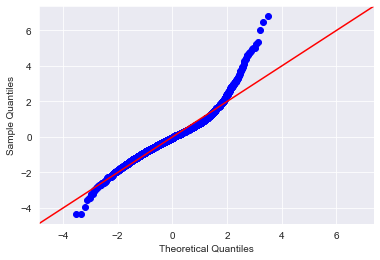

In [79]:
#CHECKING IF RESIDUALS ARE NORMALLY DISTRIBUTED
fig = sm.graphics.qqplot(model_6_test.resid, dist=stats.norm, line='45', fit=True)

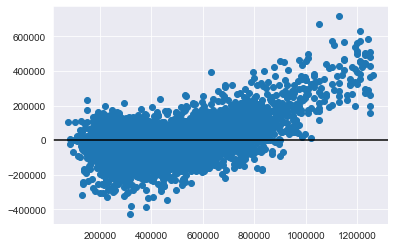

In [80]:
#CHECKING FOR HOMOSCEDACITY
plt.scatter(test_df_6['price'],model_3_test.resid)
plt.axhline(0,color='black')

**ANALYSIS**

By using zip codes instead of sub regions, the R^2 improved drastically from 71.5% to 81.3%. This means that generalizing zip codes into regions did not help the model because there is a high price variation from city to city. The test model confirmed the validity of the model, with both the train and test models varying by 1%.The residuals got worse on the tails, but they still somewhat follow a normal distribution.

# 2 - DOES LOG TRANSFORMING PRICE IMPROVE MODEL?

In [81]:
#DROPPING COLUMNS WITH HIGH CORRELATION AND COLUMNS NOT USED IN MODEL
model4_df = model6_df.copy()
model4_df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,zipcode,year_sold,renovated,house_age_when_sold,has_basement
0,221900.00000,-0.34165,-1.49928,-1.06468,-0.38152,-0.88386,0,-0.63169,-0.48295,98178,-0.69112,-0.17480,0.50835,-0.03626
1,538000.00000,-0.34165,0.38004,1.11112,-0.20888,0.96254,0,-0.63169,-0.48295,98125,-0.69112,5.72075,0.64417,27.58019
2,180000.00000,-1.64442,-1.49928,-1.70647,0.09022,-0.88386,0,-0.63169,-1.52635,98028,1.44692,-0.17480,1.28935,-0.03626
3,604000.00000,0.96111,1.50763,0.15627,-0.45201,-0.88386,0,2.46451,-0.48295,98136,-0.69112,-0.17480,0.16878,27.58019
4,510000.00000,-0.34165,0.00417,-0.28202,-0.11800,-0.88386,0,-0.63169,0.56046,98074,1.44692,-0.17480,-0.54430,-0.03626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.00000,-0.34165,0.75590,-0.51682,-0.87159,2.80895,0,-0.63169,0.56046,98103,-0.69112,-0.17480,-1.32530,-0.03626
21593,400000.00000,0.96111,0.75590,0.70414,-0.36385,0.96254,0,-0.63169,0.56046,98146,1.44692,-0.17480,-1.46112,-0.03626
21594,402101.00000,-1.64442,-1.87514,-1.31514,-0.84784,0.96254,0,-0.63169,-0.48295,98144,-0.69112,-0.17480,-1.32530,-0.03626
21595,400000.00000,-0.34165,0.75590,-0.40725,-0.73528,0.96254,0,-0.63169,0.56046,98027,1.44692,-0.17480,-1.12156,-0.03626


In [82]:
#HOT ENCODING
dummies = pd.get_dummies(model4_df[categories_2],prefix = categories_2,drop_first = True)
df_preprocessed_4 = model4_df.drop(categories_2,axis = 1)
df_preprocessed_4 = pd.concat([df_preprocessed_4,dummies],axis = 1)
df_preprocessed_4

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,year_sold,renovated,house_age_when_sold,has_basement,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,...,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,waterfront_1
0,221900.00000,-0.34165,-1.49928,-1.06468,-0.38152,-0.88386,-0.63169,-0.48295,-0.69112,-0.17480,0.50835,-0.03626,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,538000.00000,-0.34165,0.38004,1.11112,-0.20888,0.96254,-0.63169,-0.48295,-0.69112,5.72075,0.64417,27.58019,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,180000.00000,-1.64442,-1.49928,-1.70647,0.09022,-0.88386,-0.63169,-1.52635,1.44692,-0.17480,1.28935,-0.03626,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,604000.00000,0.96111,1.50763,0.15627,-0.45201,-0.88386,2.46451,-0.48295,-0.69112,-0.17480,0.16878,27.58019,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,510000.00000,-0.34165,0.00417,-0.28202,-0.11800,-0.88386,-0.63169,0.56046,1.44692,-0.17480,-0.54430,-0.03626,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.00000,-0.34165,0.75590,-0.51682,-0.87159,2.80895,-0.63169,0.56046,-0.69112,-0.17480,-1.32530,-0.03626,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
21593,400000.00000,0.96111,0.75590,0.70414,-0.36385,0.96254,-0.63169,0.56046,1.44692,-0.17480,-1.46112,-0.03626,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
21594,402101.00000,-1.64442,-1.87514,-1.31514,-0.84784,0.96254,-0.63169,-0.48295,-0.69112,-0.17480,-1.32530,-0.03626,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
21595,400000.00000,-0.34165,0.75590,-0.40725,-0.73528,0.96254,-0.63169,0.56046,1.44692,-0.17480,-1.12156,-0.03626,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [83]:
#CREATING LOG PRICE COLUMN IN DF
df_preprocessed_4['log_price'] = df_preprocessed_4['price'].map(lambda x :np.log(x))
df_preprocessed_4

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,year_sold,renovated,house_age_when_sold,has_basement,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,...,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,waterfront_1,log_price
0,221900.00000,-0.34165,-1.49928,-1.06468,-0.38152,-0.88386,-0.63169,-0.48295,-0.69112,-0.17480,0.50835,-0.03626,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,12.30998
1,538000.00000,-0.34165,0.38004,1.11112,-0.20888,0.96254,-0.63169,-0.48295,-0.69112,5.72075,0.64417,27.58019,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13.19561
2,180000.00000,-1.64442,-1.49928,-1.70647,0.09022,-0.88386,-0.63169,-1.52635,1.44692,-0.17480,1.28935,-0.03626,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12.10071
3,604000.00000,0.96111,1.50763,0.15627,-0.45201,-0.88386,2.46451,-0.48295,-0.69112,-0.17480,0.16878,27.58019,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,13.31133
4,510000.00000,-0.34165,0.00417,-0.28202,-0.11800,-0.88386,-0.63169,0.56046,1.44692,-0.17480,-0.54430,-0.03626,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13.14217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.00000,-0.34165,0.75590,-0.51682,-0.87159,2.80895,-0.63169,0.56046,-0.69112,-0.17480,-1.32530,-0.03626,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12.79386
21593,400000.00000,0.96111,0.75590,0.70414,-0.36385,0.96254,-0.63169,0.56046,1.44692,-0.17480,-1.46112,-0.03626,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,12.89922
21594,402101.00000,-1.64442,-1.87514,-1.31514,-0.84784,0.96254,-0.63169,-0.48295,-0.69112,-0.17480,-1.32530,-0.03626,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,12.90446
21595,400000.00000,-0.34165,0.75590,-0.40725,-0.73528,0.96254,-0.63169,0.56046,1.44692,-0.17480,-1.12156,-0.03626,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12.89922


In [84]:
#DEFINING TARGET AND PREDICTORS
y = 'log_price'
df_predictors_4 = df_preprocessed_4.drop(['log_price','price'],axis = 1)
X_4 = list(df_predictors_4.columns)

In [85]:
#TEST-TRAIN SPLIT
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(df_preprocessed_4[X_4], df_preprocessed_4[y], test_size=0.25, random_state=69)
print(len(X_train_4), len(X_test_4), len(y_train_4), len(y_test_4))

13710 4570 13710 4570


In [86]:
#COMBINING XTRAIN YTRAIN AND XTEST YTEST
train_df_4 = pd.concat([y_train_4,X_train_4],axis=1)
test_df_4 = pd.concat([y_test_4,X_test_4],axis=1)

In [87]:
#FITTING MODEL
predictors_4 = '+'.join(X_train_4.columns)
formula = y + '~' + predictors_4
model_4 = ols(formula=formula, data=train_df_4).fit()
model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     851.8
Date:                Sun, 02 Aug 2020   Prob (F-statistic):               0.00
Time:                        16:32:08   Log-Likelihood:                 4180.2
No. Observations:               13710   AIC:                            -8196.
Df Residuals:                   13628   BIC:                            -7579.
Df Model:                          81                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              12.5097      0.011   1118.064      0.000      12.488      12.532
bedrooms               -0.0068      0.002     -3.426      0.001      -0.011      -0.003
bathrooms               0.0218      0.003      8.431      0.000       0.017       0.027
sqft_living             0.1703      0.003     58.998      0.000       0.165       0.176
sqft_lot                0.0247      0.002     13.423      0.000       0.021       0.028
floors                 -0.0060      0.002     -2.811      0.005      -0.010      -0.002
condition               0.0309      0.002     17.741      0.000       0.027       0.034
grade                   0.1034      0.003     40.817      0.000       0.098       0.108
year_sold               0.0258      0.002     16.765      0.000       0.023       0.029
renovated               0.0092      0.002      5.669      0.000       0.006       0.012
house_age_when_sold     0.0282      0.003     10.502      0.000       0.023       0.033
has_basement            0.0018      0.002      1.068      0.286      -0.001       0.005
zipcode_98002          -0.0319      0.019     -1.714      0.087      -0.068       0.005
zipcode_98003           0.0192      0.017      1.129      0.259      -0.014       0.053
zipcode_98004           1.0529      0.020     52.990      0.000       1.014       1.092
zipcode_98005           0.7452      0.022     34.102      0.000       0.702       0.788
zipcode_98006           0.6389      0.016     39.119      0.000       0.607       0.671
zipcode_98007           0.6481      0.022     29.361      0.000       0.605       0.691
zipcode_98008           0.6513      0.017     37.560      0.000       0.617       0.685
zipcode_98010           0.2132      0.027      7.758      0.000       0.159       0.267
zipcode_98011           0.4620      0.019     23.940      0.000       0.424       0.500
zipcode_98014           0.2712      0.027      9.867      0.000       0.217       0.325
zipcode_98019           0.3302      0.020     16.198      0.000       0.290       0.370
zipcode_98022           0.0331      0.019      1.718      0.086      -0.005       0.071
zipcode_98023          -0.0372      0.015     -2.532      0.011      -0.066      -0.008
zipcode_98024           0.3751      0.036     10.522      0.000       0.305       0.445
zipcode_98027           0.5406      0.017     32.755      0.000       0.508       0.573
zipcode_98028           0.4167      0.017     24.081      0.000       0.383       0.451
zipcode_98029           0.6012      0.016     36.656      0.000       0.569       0.633
zipcode_98030           0.0399      0.018      2.268      0.023       0.005       0.074
zipcode_98031           0.0623      0.017      3.623      0.000       0.029       0.096
zipcode_98032          -0.0271      0.023     -1.169      0.242      -0.072       0.018
zip

In [88]:
#REMOVING FEATURES WITH P-VALUE > 0.05
summary_4 = model_4.summary()
p_table_4 = summary_4.tables[1]
p_table_4 = pd.DataFrame(p_table_4.data)
p_table_4.columns = p_table_4.iloc[0]
p_table_4 = p_table_4.drop(0)
p_table_4 = p_table_4.set_index(p_table_4.columns[0])
p_table_4['P>|t|'] = p_table_4['P>|t|'].astype(float)
x_cols_4 = list(p_table_4[p_table_4['P>|t|'] < 0.05].index)
x_cols_4.remove('Intercept')
print(len(p_table_4), len(x_cols_4))

82 75


In [89]:
#FITTING REVISED MODEL
predictors_4 = '+'.join(x_cols_4)
formula = y + '~' + predictors_4
model_4 = ols(formula=formula, data=train_df_4).fit()
model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     919.2
Date:                Sun, 02 Aug 2020   Prob (F-statistic):               0.00
Time:                        16:32:08   Log-Likelihood:                 4173.1
No. Observations:               13710   AIC:                            -8194.
Df Residuals:                   13634   BIC:                            -7622.
Df Model:                          75                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              12.5112      0.006   2186.021      0.000      12.500      12.522
bedrooms               -0.0070      0.002     -3.500      0.000      -0.011      -0.003
bathrooms               0.0219      0.003      8.470      0.000       0.017       0.027
sqft_living             0.1703      0.003     58.992      0.000       0.165       0.176
sqft_lot                0.0250      0.002     13.589      0.000       0.021       0.029
floors                 -0.0061      0.002     -2.870      0.004      -0.010      -0.002
condition               0.0308      0.002     17.704      0.000       0.027       0.034
grade                   0.1037      0.003     41.033      0.000       0.099       0.109
year_sold               0.0258      0.002     16.757      0.000       0.023       0.029
renovated               0.0093      0.002      5.717      0.000       0.006       0.012
house_age_when_sold     0.0280      0.003     10.449      0.000       0.023       0.033
zipcode_98004           1.0517      0.017     60.536      0.000       1.018       1.086
zipcode_98005           0.7434      0.020     37.861      0.000       0.705       0.782
zipcode_98006           0.6371      0.013     48.322      0.000       0.611       0.663
zipcode_98007           0.6471      0.020     32.589      0.000       0.608       0.686
zipcode_98008           0.6498      0.014     45.060      0.000       0.622       0.678
zipcode_98010           0.2113      0.026      8.193      0.000       0.161       0.262
zipcode_98011           0.4603      0.017     27.463      0.000       0.427       0.493
zipcode_98014           0.2692      0.026     10.425      0.000       0.219       0.320
zipcode_98019           0.3284      0.018     18.212      0.000       0.293       0.364
zipcode_98023          -0.0387      0.011     -3.475      0.001      -0.061      -0.017
zipcode_98024           0.3736      0.034     10.870      0.000       0.306       0.441
zipcode_98027           0.5387      0.013     40.060      0.000       0.512       0.565
zipcode_98028           0.4150      0.014     28.773      0.000       0.387       0.443
zipcode_98029           0.5994      0.013     45.106      0.000       0.573       0.625
zipcode_98030           0.0386      0.015      2.612      0.009       0.010       0.068
zipcode_98031           0.0607      0.014      4.253      0.000       0.033       0.089
zipcode_98033           0.7608      0.013     60.291      0.000       0.736       0.786
zipcode_98034           0.5288      0.011     48.593      0.000       0.508       0.550
zipcode_98038           0.1688      0.011     15.439      0.000       0.147       0.190
zipcode_98039           1.2401      0.073     16.911      0.000       1.096       1.384
zipcode_98040           0.8639      0.019     45.525      0.000       0.827       0.901
zip

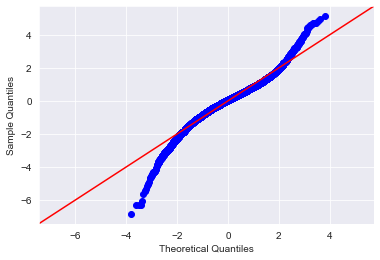

In [90]:
#CHECKING IF RESIDUALS ARE NORMALLY DISTRIBUTED
fig = sm.graphics.qqplot(model_4.resid, dist=stats.norm, line='45', fit=True)

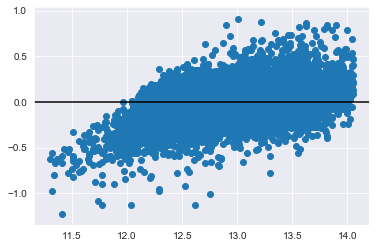

In [91]:
#CHECKING FOR HOMOSCEDACITY
plt.scatter(train_df_4['log_price'],model_4.resid)
plt.axhline(0,color='black')

**ANALYSIS**

By log transforming the target value (Price), the interpretability of the model decreased drastically without adding too much benefit. The R^2 only increased around 1%. The best model is still Model6, which uses the zip codes instead of sub regions. Did not do test model because did not see the benefit of doing so.

# 3 - MOST/LEAST IMPORTANT FEATURES

In [131]:
#CREATING DF FOR MODEL 6 (ZIPCODE MODEL) COEFS
param_df = pd.DataFrame(model_6_test.params)
param_df.reset_index(inplace=True)
param_df.rename(columns={'index':'features',0:'coef'},inplace=True)

#DROPPING COLUMNS THAT CONTAIN ZIPCODES BECAUSE THEY ARE SO MANY AND THEY AREN'T TOO RELEVANT
#TO SUGGEST CHANGES TO A HOUSE
param_df[~param_df['features'].str.contains('zipcode')].sort_values(by='coef')

,features,coef
1,bedrooms,-3760.19290
8,renovated,3931.15580
2,bathrooms,7366.88007
4,sqft_lot,8432.04516
7,year_sold,10195.84810
5,condition,14101.05036
9,house_age_when_sold,18756.89234
6,grade,49846.23288
3,sqft_living,83786.85810
68,waterfront_1,140560.58913


**ANALYSIS**

Some of the most important features in a house are being located near the waterfront, sqft living, grade, and age of the house when sold.

Some of the least important features are number of bedrooms and bathrooms, lot size, and if the house was renovated or not.

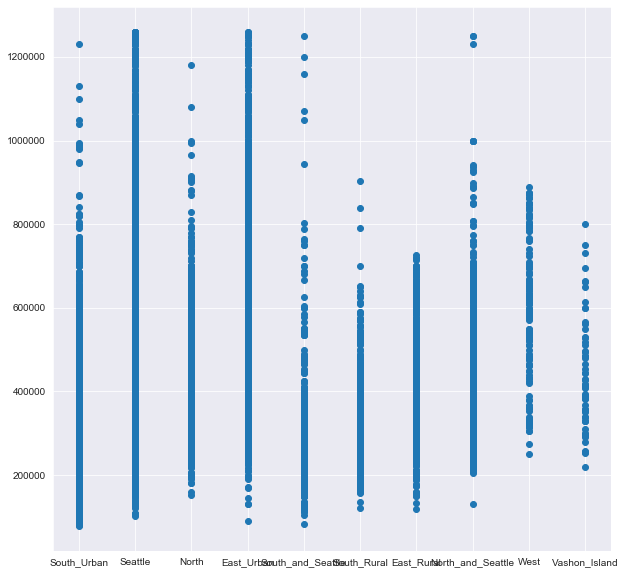

In [139]:
# fig,axes = plt.subplots(figsize=(6,10),ncols=1,nrows=3)
# axes = axes.flatten()
# sns.scatterplot('Sub_Region','price',df,ax=axes[0],scatter_kws=dict(alpha=0.6),
#             line_kws={'color':'green', 'ls':':'})
# axes[0].set_title(f"Linearity Check ({col} vs {target})")
# axes[0].yaxis.set_major_formatter(price_fmt)

# sns.distplot(df[col],ax=axes[1])
# axes[1].set_title(f"Distribution of {col}")
plt.figure(figsize=(10,10))
plt.scatter(df['Sub_Region'],df['price']);

# CONCLUSIONS & RECOMMENDATIONS

> Summarize your conclusions and bullet-point your list of recommendations, which are based on your modeling results.